## Uplift Random Forest Benchmark

H2O cloud is inicialize before every run and shutdown after every run. Algorithm is firstly tested on Training performance and after on Evaluation performance.

* N = number of rows
* P = number of collumns
* max_depth = how big is the depth of the tree

Computer parameters:
 * Lenovo ThinkPad P53,
 * MS Windows 10 Pro x64,
 * Intel Core i7-9850H CPU @ 2.60GHz,
 * 6 cores and 12 threads,
 * 96.0 GB RAM.

In [1]:
import sys
sys.path.append("../../../../h2o-py/build/main") # path to h2o build

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import time
import math
import random
import h2o
from h2o.estimators import H2ORandomForestEstimator, H2OGradientBoostingEstimator
from h2o.estimators import H2OUpliftRandomForestEstimator
from causalml.dataset import make_uplift_classification

versionFromGradle='3.35.0',projectVersion='3.35.0.99999',branch='maurever_PUBDEV-4940_uplift_trees_poc',lastCommitHash='8760916c9e1f20da963020fb7b7a6b7fd12269dc',gitDescribe='jenkins-master-5592-3-g8760916c9e-dirty',compiledOn='2021-10-20 15:09:29',compiledBy='potte'


The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [3]:
# Notebook parameters
N = 100000
P = 20

seed = 1234
ntrees = 100
attempt_per_thread = 10 # number of runs of the algorithm in the thread
threds = [12, 10, 8, 6, 4, 2, 1]
nbins = 1000
nbins_top_level=1024

#Parameters to test
max_depths = [8, 16, 20]
nbinss = [20, 400, 2000]

In [4]:
def syntetic_data(N, P):
    train, x_names = make_uplift_classification(n_samples=N,
                                                treatment_name=['control', 'treatment'],
                                                n_classification_features=P,
                                                n_classification_informative=P,
                                                random_seed=seed
                                                )

    treatment_column = "treatment_group_key"
    response_column = "conversion"


    return train, x_names, treatment_column, response_column

def train_models(nthreads, data, start_cluster=True):
    if start_cluster:
        h2o.init(nthreads=nthreads)
    start = time.time()
    hf = h2o.H2OFrame(data)
    hf[treatment_column] = hf[treatment_column].asfactor()
    hf[response_column] = hf[response_column].asfactor()
    uplift_h2o = H2OUpliftRandomForestEstimator(        
                                                ntrees=ntrees,
                                                max_depth=max_depth,
                                                treatment_column=treatment_column,
                                                uplift_metric="KL",
                                                distribution="bernoulli",
                                                gainslift_bins=10,
                                                min_rows=10,
                                                nbins_top_level=nbins_top_level,
                                                nbins=nbins,
                                                seed=seed,
                                                sample_rate=0.99,
                                                auuc_type="gain"
                                                )
    uplift_h2o.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    uplift_time = end - start
    print(f"Uplift Time: {uplift_time}s")
    start = time.time()
    rf_h2o = H2ORandomForestEstimator(        
                                      ntrees=ntrees,
                                      max_depth=max_depth,
                                      distribution="bernoulli",
                                      gainslift_bins=10,
                                      min_rows=10,
                                      nbins_top_level=nbins_top_level,
                                      nbins=nbins,
                                      seed=seed,
                                      sample_rate=0.99,
                                      binomial_double_trees=True,
                                      score_tree_interval=ntrees+1
                                    )
    rf_h2o.train(y=response_column, x=x_names, training_frame = hf)
    end = time.time()
    rf_time = end - start
    print(f"RF Time: {rf_time}s")
    start = time.time()
    gbm = H2OGradientBoostingEstimator(        
                                        ntrees=ntrees,
                                        max_depth=max_depth,
                                        distribution="bernoulli",
                                        gainslift_bins=10,
                                        min_rows=10,
                                        nbins_top_level=nbins_top_level,
                                        nbins=nbins,
                                        seed=seed,
                                        sample_rate=0.99,
                                        score_tree_interval=ntrees+1
                                      )
    gbm.train(y=response_column, x=x_names, training_frame=hf)
    end = time.time()
    gbm_time = end - start
    print(f"gbm Time: {gbm_time}s")    
    if start_cluster:
        h2o.cluster().shutdown()
    return uplift_time, rf_time, gbm_time


def run_benchmark(data, start_cluster=True):
    all_times = []
    all_times_num_uplift = []
    all_times_num_rf = []
    all_times_num_gbm = []
    for nthreads in threds:
        times_uplift = []
        times_rf = []
        times_gbm = []
        for i in range(attempt_per_thread):
            uplift_time, rf_time, gbm_time = train_models(nthreads, data, start_cluster)
            times_uplift.append(uplift_time)
            times_rf.append(rf_time)
            times_gbm.append(gbm_time)
        print(f"Uplift {np.mean(times_uplift)}s")
        print(f"RF {np.mean(times_rf)}s")
        print(f"gbm {np.mean(times_gbm)}s")
        all_times_num_uplift.append(times_uplift)
        all_times_num_rf.append(times_rf)
        all_times_num_gbm.append(times_gbm)
        all_times.append(f"thread {nthreads} - Uplift {np.mean(times_uplift)}s and RF {np.mean(times_rf)}s and gbm {np.mean(times_gbm)}s")

    uplift_means = dict()
    rf_means = dict()
    gbm_means = dict()
    for i, nthreads in enumerate(threds):
        print(f"{nthreads} - Uplift = {np.mean(all_times_num_uplift[i])}, RF = {np.mean(all_times_num_rf[i])}, gbm = {np.mean(all_times_num_gbm[i])}")
        uplift_means[nthreads] = np.mean(all_times_num_uplift[i])
        rf_means[nthreads] = np.mean(all_times_num_rf[i])
        gbm_means[nthreads] = np.mean(all_times_num_gbm[i])
    
    return uplift_means, rf_means, gbm_means
        
    
def plot_result(eif_means, if_means, gbm_means):
    data = {"x":[], "y": [], "label":[]}
    for label, coord in eif_means.items():
        data["x"].append(label)
        data["y"].append(coord)

    data_if = {"x":[], "y": [], "label":[]}
    for label, coord in if_means.items():
        data_if["x"].append(label)
        data_if["y"].append(coord)    
        
    data_gbm = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_means.items():
        data_gbm["x"].append(label)
        data_gbm["y"].append(coord)         

    fig=plt.figure(figsize=(8,10))
    fig.add_subplot(111)
    plt.plot(data['x'], data['y'], '-', label="UpliftRF", linewidth=3)
    plt.plot(data_if['x'], data_if['y'], '-', label="RF", linewidth=3)
    plt.plot(data_gbm['x'], data_gbm['y'], '-', label="GBM", linewidth=3)
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"Uplift Random Forest - training benchmark\nModel: N = {N}; P = {P}; ntrees = {ntrees};  max_depth = {max_depth}; nbins = {nbins}")
    plt.savefig(f"h2o-scale-perf_{max_depth}_{N}_{coord}.png", bbox_inches='tight', pad_inches=.05)
    plt.show()



## Training stage

In [5]:
N = 100000
P = 20
max_depth = max_depths[0]
print(f"max_depth = {max_depth}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

max_depth = 8


In [6]:
uplift_time7, rf_time7, gbm_time7 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7fg_7xxl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7fg_7xxl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7fg_7xxl\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 minutes
H2O_cluster_name:,H2O_from_python_potte_jm0s7t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.108551263809204s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.105707168579102s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.31803274154663s
H2O session _sid_9a00 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6dqo6u3n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6dqo6u3n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6dqo6u3n\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 minutes
H2O_cluster_name:,H2O_from_python_potte_fpuvn0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 38.07680702209473s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.865996837615967s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.059983968734741s
H2O session _sid_a1fc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7iq2de2h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7iq2de2h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7iq2de2h\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 minutes
H2O_cluster_name:,H2O_from_python_potte_ucju6q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.92385983467102s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.264273643493652s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.43505072593689s
H2O session _sid_b77b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4kr9q9dz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4kr9q9dz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4kr9q9dz\h2o_potte_started_from_python.er

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 minutes
H2O_cluster_name:,H2O_from_python_potte_cufpuz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 38.09183311462402s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.220597505569458s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.123343467712402s
H2O session _sid_b023 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxwjg8l7m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxwjg8l7m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxwjg8l7m\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 minutes
H2O_cluster_name:,H2O_from_python_potte_l19s5x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.68204474449158s
drf Model Build progress: |███████████████████████████████████████████████████████████| (done) 100%
RF Time: 9.093149900436401s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.071905612945557s
H2O session _sid_a946 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphcnm7ysi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphcnm7ysi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphcnm7ysi\h2o_potte_started_from_pyt

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 minutes
H2O_cluster_name:,H2O_from_python_potte_ud1lak
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.907089948654175s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.726277112960815s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.833795309066772s
H2O session _sid_8870 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr3dmuiv2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr3dmuiv2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr3dmuiv2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 minutes
H2O_cluster_name:,H2O_from_python_potte_p1x3vr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.144941091537476s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.893142700195312s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.57608675956726s
H2O session _sid_a2f2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx_xcup14
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx_xcup14\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx_xcup14\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 minutes
H2O_cluster_name:,H2O_from_python_potte_cyh4ey
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 37.08423948287964s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.034414768218994s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.503710985183716s
H2O session _sid_b408 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2b7ux7ri
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2b7ux7ri\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2b7ux7ri\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,24 minutes
H2O_cluster_name:,H2O_from_python_potte_l297f3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 38.224398374557495s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.255242824554443s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.064834117889404s
H2O session _sid_8d78 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5yko0v79
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5yko0v79\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5yko0v79\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,25 minutes
H2O_cluster_name:,H2O_from_python_potte_uhm744
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.753570795059204s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.273879289627075s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 13.440601110458374s
H2O session _sid_ac60 closed.
Uplift 37.29973356723785s
RF 8.773268175125121s
gbm 12.842734479904175s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2kmfqmm8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2kmfqmm8\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,27 minutes
H2O_cluster_name:,H2O_from_python_potte_2jbnyz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.53374791145325s
drf Model Build progress: |██████████████████████████████████████████████████████████| (done) 100%
RF Time: 8.610971927642822s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.87714958190918s
H2O session _sid_863f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg7se3cpp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg7se3cpp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg7se3cpp\h2o_potte_started_from_pytho

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,28 minutes
H2O_cluster_name:,H2O_from_python_potte_ktoxf7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.466591358184814s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.804338216781616s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.309297561645508s
H2O session _sid_b3e5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcx5xzlyc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcx5xzlyc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcx5xzlyc\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,29 minutes
H2O_cluster_name:,H2O_from_python_potte_1mjcx0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.06513786315918s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.915338516235352s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.105296850204468s
H2O session _sid_95fc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu6wp0d02
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu6wp0d02\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu6wp0d02\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,31 minutes
H2O_cluster_name:,H2O_from_python_potte_28ml49
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.54892921447754s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.075877904891968s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.970746278762817s
H2O session _sid_b7aa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp18rs4jlh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp18rs4jlh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp18rs4jlh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,32 minutes
H2O_cluster_name:,H2O_from_python_potte_3lpfti
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.289390087127686s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.185523271560669s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.02816653251648s
H2O session _sid_a421 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6gyaqhr9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6gyaqhr9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6gyaqhr9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,33 minutes
H2O_cluster_name:,H2O_from_python_potte_npauq2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.397188901901245s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.088698387145996s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.239081621170044s
H2O session _sid_afa0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptiru56sm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptiru56sm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptiru56sm\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,35 minutes
H2O_cluster_name:,H2O_from_python_potte_pdq0fy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.514827251434326s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.757465362548828s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.118948221206665s
H2O session _sid_abc3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk4vf77ub
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk4vf77ub\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk4vf77ub\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,36 minutes
H2O_cluster_name:,H2O_from_python_potte_gvzlcz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.06290888786316s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.724200248718262s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.070404291152954s
H2O session _sid_8cad closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw3wf0h4j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw3wf0h4j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpw3wf0h4j\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,37 minutes
H2O_cluster_name:,H2O_from_python_potte_g79yn1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.53719615936279s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.306334733963013s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.091196775436401s
H2O session _sid_933b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpshlm8qli
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpshlm8qli\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpshlm8qli\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,39 minutes
H2O_cluster_name:,H2O_from_python_potte_cqxni5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.270853996276855s
drf Model Build progress: |███████████████████████████████████████████████████████████| (done) 100%
RF Time: 8.642825365066528s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.012476682662964s
H2O session _sid_ac6f closed.
Uplift 35.16867716312409s
RF 8.511157393455505s
gbm 12.082276439666748s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8er2jc0q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8er2jc0q\h2o_potte_started_from_python.out
  JVM stderr:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,40 minutes
H2O_cluster_name:,H2O_from_python_potte_5v6s9d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.241414070129395s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.476580142974854s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.799233436584473s
H2O session _sid_90b1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp52gn3vf8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp52gn3vf8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp52gn3vf8\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,41 minutes
H2O_cluster_name:,H2O_from_python_potte_ktgkkd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.28608822822571s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.540177345275879s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.55913782119751s
H2O session _sid_8e9f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp75syzatl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp75syzatl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp75syzatl\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,43 minutes
H2O_cluster_name:,H2O_from_python_potte_7gus4q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.82675838470459s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.517083168029785s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.593491554260254s
H2O session _sid_ad74 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwql6elos
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwql6elos\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwql6elos\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,44 minutes
H2O_cluster_name:,H2O_from_python_potte_9pq8yj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.15728235244751s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.55020523071289s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.729737997055054s
H2O session _sid_9a41 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8lyfavzw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8lyfavzw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8lyfavzw\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,45 minutes
H2O_cluster_name:,H2O_from_python_potte_qz9r14
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.15331506729126s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.63918948173523s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.586891412734985s
H2O session _sid_b56b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpugjz1ou8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpugjz1ou8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpugjz1ou8\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,47 minutes
H2O_cluster_name:,H2O_from_python_potte_m3azt2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.129058599472046s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.539716243743896s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.712793111801147s
H2O session _sid_aad6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp446pipc5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp446pipc5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp446pipc5\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,48 minutes
H2O_cluster_name:,H2O_from_python_potte_1simdg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.15585017204285s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.646382570266724s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.695414066314697s
H2O session _sid_954e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6gefbm5k
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6gefbm5k\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6gefbm5k\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,49 minutes
H2O_cluster_name:,H2O_from_python_potte_yptmwx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.8139009475708s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.706440448760986s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.645660877227783s
H2O session _sid_83ec closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc0vu53ba
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc0vu53ba\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc0vu53ba\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,51 minutes
H2O_cluster_name:,H2O_from_python_potte_li05xf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.12031292915344s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.667988061904907s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.611770391464233s
H2O session _sid_983f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0zynsix3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0zynsix3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0zynsix3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,52 minutes
H2O_cluster_name:,H2O_from_python_potte_kugmqm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 34.17268896102905s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.61634349822998s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.820865631103516s
H2O session _sid_8f54 closed.
Uplift 35.005666971206665s
RF 8.590010619163513s
gbm 11.675499629974365s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx60f3w0d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx60f3w0d\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,53 minutes
H2O_cluster_name:,H2O_from_python_potte_5pt1n7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.662765979766846s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.865181684494019s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.855299949645996s
H2O session _sid_a4b2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb4hyktir
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb4hyktir\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb4hyktir\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,55 minutes
H2O_cluster_name:,H2O_from_python_potte_wje309
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.76568961143494s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.681064128875732s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.829950094223022s
H2O session _sid_9301 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0gimyepu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0gimyepu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0gimyepu\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,56 minutes
H2O_cluster_name:,H2O_from_python_potte_7pzldn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.66651630401611s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.612611770629883s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.142000675201416s
H2O session _sid_95e4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp94wwqbdh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp94wwqbdh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp94wwqbdh\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,57 minutes
H2O_cluster_name:,H2O_from_python_potte_9rf6hz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.49472236633301s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.506974935531616s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.643370389938354s
H2O session _sid_89c1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8aj_f64v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8aj_f64v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8aj_f64v\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,59 minutes
H2O_cluster_name:,H2O_from_python_potte_no9hsj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.54966855049133s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.622125625610352s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.801247596740723s
H2O session _sid_9d87 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa7qghhrx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa7qghhrx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa7qghhrx\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour
H2O_cluster_name:,H2O_from_python_potte_30lczm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.49080157279968s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.542375087738037s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.70725417137146s
H2O session _sid_8b3a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqw7_830m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqw7_830m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqw7_830m\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 1 minute
H2O_cluster_name:,H2O_from_python_potte_ppg2e1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.4936683177948s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.63359260559082s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.800034046173096s
H2O session _sid_99a4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfj88kmjn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfj88kmjn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfj88kmjn\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_4ho6ro
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.65874147415161s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.54377269744873s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.805620193481445s
H2O session _sid_9577 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprragb_dz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprragb_dz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprragb_dz\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_l0dwir
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 35.74748253822327s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.559225082397461s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.774751901626587s
H2O session _sid_8cc5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzrr5yft_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzrr5yft_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzrr5yft_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_w0wjqc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 36.53075122833252s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 8.636909008026123s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 11.81264615058899s
H2O session _sid_a2d6 closed.
Uplift 36.30608079433441s
RF 8.620383262634277s
gbm 11.81721751689911s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9hnj5phl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9hnj5phl\h2o_potte_started_from_python.out
  JVM stderr: C:\User

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_bng07s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.70030188560486s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.849235534667969s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.773382186889648s
H2O session _sid_8fac closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2id40scj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2id40scj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2id40scj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_ggk2tc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.464869022369385s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.681316375732422s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.167042016983032s
H2O session _sid_be5d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4ssnaxy_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4ssnaxy_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4ssnaxy_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_x9ctmo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.52568960189819s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.641925573348999s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.924267768859863s
H2O session _sid_8b50 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmnkydp94
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmnkydp94\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmnkydp94\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_ujbedy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.55095624923706s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.85092043876648s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.747555255889893s
H2O session _sid_9ff7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu22_bota
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu22_bota\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu22_bota\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_usg8or
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.52903652191162s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.574126482009888s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.732692241668701s
H2O session _sid_94b2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwqxlbrzs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwqxlbrzs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwqxlbrzs\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_qg05ba
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.7414288520813s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.69873595237732s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.859277248382568s
H2O session _sid_ae2f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5dxid7_t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5dxid7_t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5dxid7_t\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_4f98qk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.60582685470581s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.73368763923645s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.815687894821167s
H2O session _sid_8db1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpprymprvd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpprymprvd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpprymprvd\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_fnjdan
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 39.24673247337341s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.649006843566895s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.679321050643921s
H2O session _sid_9b42 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpya09rkad
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpya09rkad\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpya09rkad\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_qbgnxw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.55950355529785s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.788066625595093s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.919471263885498s
H2O session _sid_8be4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3jt7_898
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3jt7_898\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3jt7_898\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 20 minutes
H2O_cluster_name:,H2O_from_python_potte_pnfmj9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 40.879807472229004s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 9.862589120864868s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 12.810477495193481s
H2O session _sid_a8d6 closed.
Uplift 40.08041524887085s
RF 9.732961058616638s
gbm 12.742917442321778s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyq809u4h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyq809u4h\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_kuttxn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.74618053436279s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.349202871322632s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 19.93840742111206s
H2O session _sid_9f58 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpba_jmfcs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpba_jmfcs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpba_jmfcs\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 23 minutes
H2O_cluster_name:,H2O_from_python_potte_pmwbtk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.40255570411682s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.099751472473145s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 19.99167776107788s
H2O session _sid_b178 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqrb0pgsd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqrb0pgsd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqrb0pgsd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_3mlg46
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.45176362991333s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.149146318435669s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.42663884162903s
H2O session _sid_86bf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptydireo0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptydireo0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptydireo0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_g2etn8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.54885196685791s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.057616233825684s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 19.812444925308228s
H2O session _sid_8213 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj9s_qk22
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj9s_qk22\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpj9s_qk22\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_7r3tf3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.92388701438904s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.199527025222778s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.50687003135681s
H2O session _sid_9230 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpck3ynczv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpck3ynczv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpck3ynczv\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_398345
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.473817348480225s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.126180648803711s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.33548617362976s
H2O session _sid_bb9e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpixfmrlkl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpixfmrlkl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpixfmrlkl\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_oik3bc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.14323091506958s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.182553768157959s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.64406132698059s
H2O session _sid_880c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvj1dpr97
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvj1dpr97\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvj1dpr97\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_equypd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 62.530060052871704s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.101875066757202s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.54696750640869s
H2O session _sid_b762 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptymtczhg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptymtczhg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptymtczhg\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_knlxm3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.16667890548706s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.051173686981201s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.579443216323853s
H2O session _sid_aafb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg727p3ix
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg727p3ix\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg727p3ix\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_obpfr3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 61.348172187805176s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 15.184840440750122s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 20.651085376739502s
H2O session _sid_be79 closed.
Uplift 61.77351982593537s
RF 15.15018675327301s
gbm 20.34330825805664s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2y4tf8o_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2y4tf8o_\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_v8ru1l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 105.6200065612793s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.222594261169434s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.07217502593994s
H2O session _sid_824b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzsl8vpgl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzsl8vpgl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzsl8vpgl\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_b7amzf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.0834047794342s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.94217586517334s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.49922561645508s
H2O session _sid_939e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu839i8ev
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu839i8ev\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu839i8ev\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_z9wvbq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 108.40048909187317s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.830012321472168s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.379286766052246s
H2O session _sid_bc70 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp83_nc95f
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp83_nc95f\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp83_nc95f\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_iedcp2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.97520160675049s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.26017451286316s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 35.534302711486816s
H2O session _sid_9b2f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq7ks35lr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq7ks35lr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq7ks35lr\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_lne0cp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.7902443408966s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.936877727508545s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.17937779426575s
H2O session _sid_936d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmgw_aowd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmgw_aowd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmgw_aowd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 hour and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_lcmkd8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.74934077262878s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.929181575775146s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.149211168289185s
H2O session _sid_a3ce closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvnw8lv6p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvnw8lv6p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvnw8lv6p\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 1 minute
H2O_cluster_name:,H2O_from_python_potte_8zj950
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.83517909049988s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.926161289215088s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.37199783325195s
H2O session _sid_9fc1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy42e0phl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy42e0phl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy42e0phl\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_8olqf3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.7337052822113s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.911012172698975s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.320318937301636s
H2O session _sid_9a71 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnevvdftz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnevvdftz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnevvdftz\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_j1jq7c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 108.11933612823486s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.82932209968567s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.1960289478302s
H2O session _sid_9390 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsfiy2jwn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsfiy2jwn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsfiy2jwn\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_k5hmb1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 109.30676627159119s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 27.09815001487732s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 36.04801678657532s
H2O session _sid_bb4c closed.
Uplift 107.16136739253997s
RF 27.688566184043886s
gbm 36.17499415874481s
12 - Uplift = 37.29973356723785, RF = 8.773268175125121, gbm = 12.842734479904175
10 - Uplift = 35.16867716312409, RF = 8.511157393455505, gbm = 12.082276439666748
8 - Uplift = 35.005666971206665, RF = 8.590010619163513, gbm = 11.675499629974365
6 - Uplift = 36.30608079433441, RF = 8.620383262634277, gbm = 11.81721751689911
4 - Uplift = 40.08041524887085, RF = 9.732961058616638, gbm = 12.742917442321778
2 - Uplift = 61.7735

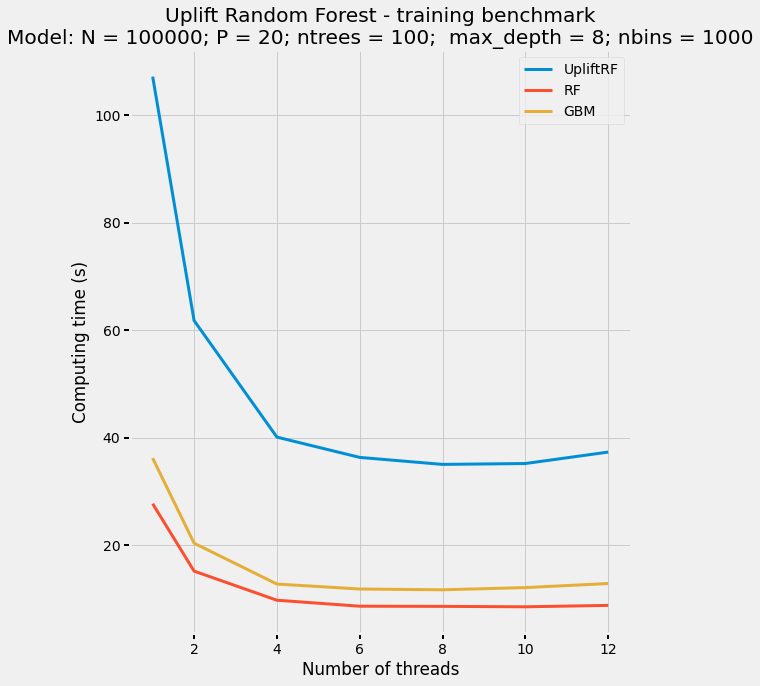

In [7]:
plot_result(uplift_time7, rf_time7, gbm_time7)

In [8]:
N = 100000
P = 20
max_depth = max_depths[1]
print(f"max_depth = {max_depth}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

max_depth = 16


In [9]:
uplift_time8, rf_time8, gbm_time8 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfvn9inkf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfvn9inkf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfvn9inkf\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_qu55m3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 204.2068498134613s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.5362663269043s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 154.2901086807251s
H2O session _sid_9071 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpopin8zoh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpopin8zoh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpopin8zoh\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_zcc9tn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 203.94959020614624s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.96936893463135s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 157.9243564605713s
H2O session _sid_a0ae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg74dhwul
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg74dhwul\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg74dhwul\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_eu3xpo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 208.50872039794922s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.67214703559875s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 155.75496792793274s
H2O session _sid_8758 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyl7h5kkp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyl7h5kkp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyl7h5kkp\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_3u57oa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 204.08225512504578s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.45638370513916s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 154.79038453102112s
H2O session _sid_ad34 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6gq_goyr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6gq_goyr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6gq_goyr\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_997wdi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 205.82161021232605s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.30754566192627s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 155.40804195404053s
H2O session _sid_8610 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpba29d8ek
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpba29d8ek\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpba29d8ek\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_wt4nfw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 205.95595335960388s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.97289395332336s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 155.92822241783142s
H2O session _sid_b8ba closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptw98caba
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptw98caba\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptw98caba\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_5orryl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 207.7454752922058s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.21323275566101s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 154.33495831489563s
H2O session _sid_a46b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp_zsflfs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp_zsflfs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp_zsflfs\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_cuyljj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 206.0706217288971s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.74741458892822s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 157.2248113155365s
H2O session _sid_aba4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq4yv2l56
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq4yv2l56\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq4yv2l56\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_u7tkjg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 205.93101477622986s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.44148182868958s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 156.47442317008972s
H2O session _sid_bc30 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk29ii3su
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk29ii3su\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk29ii3su\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_b3adwp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 205.00686526298523s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.10157012939453s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 155.98646545410156s
H2O session _sid_a1e0 closed.
Uplift 205.72789561748505s
RF 64.84183049201965s
gbm 155.81167402267457s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_vpbct4q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_vpbct4q\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_yvl206
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 191.35224890708923s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.105952739715576s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 145.0305745601654s
H2O session _sid_a61a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxk4um29i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxk4um29i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxk4um29i\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 36 minutes
H2O_cluster_name:,H2O_from_python_potte_az3t3h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 191.93063926696777s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.51403784751892s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 145.310932636261s
H2O session _sid_8967 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1si5a4ir
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1si5a4ir\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1si5a4ir\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_c5kquh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 190.73146080970764s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.43106269836426s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 142.86088347434998s
H2O session _sid_a2b1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpacqcfpip
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpacqcfpip\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpacqcfpip\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_wk6h4k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 190.59466576576233s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 57.88703775405884s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 142.87987160682678s
H2O session _sid_bb28 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpozq614jj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpozq614jj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpozq614jj\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,3 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_e3cntr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 189.7374918460846s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 60.96052861213684s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 142.84385204315186s
H2O session _sid_9c89 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph8jmngiw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph8jmngiw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph8jmngiw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_hyea66
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 190.52527260780334s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.46772003173828s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 144.15729141235352s
H2O session _sid_949e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpl3i2t0v9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpl3i2t0v9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpl3i2t0v9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 11 minutes
H2O_cluster_name:,H2O_from_python_potte_j2l75q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 192.72319269180298s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.02488040924072s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 142.93665075302124s
H2O session _sid_8b35 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcfwfg65d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcfwfg65d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcfwfg65d\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_dcrk56
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 190.92901253700256s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.28698420524597s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.89219284057617s
H2O session _sid_afcb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvqpo6y18
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvqpo6y18\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvqpo6y18\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_swo5gp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 193.19971466064453s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.89117765426636s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.78173780441284s
H2O session _sid_ae5c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpshf7q8gn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpshf7q8gn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpshf7q8gn\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_xyf5pe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 190.64374995231628s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 58.483808279037476s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 145.00020503997803s
H2O session _sid_ae7a closed.
Uplift 191.23674490451813s
RF 58.90531902313232s
gbm 143.86941921710968s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkvxn42hy
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkvxn42hy\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_06y6g8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.08132076263428s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.482588052749634s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.1972839832306s
H2O session _sid_b336 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd_v3ehy9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd_v3ehy9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd_v3ehy9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_lgm3b0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.9213342666626s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.26091384887695s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 129.7489550113678s
H2O session _sid_80dc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc1fm2cri
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc1fm2cri\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc1fm2cri\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_uatg5b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.43868160247803s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.397117614746094s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.33233976364136s
H2O session _sid_a965 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp1j7crfx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp1j7crfx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp1j7crfx\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,4 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_be0hgi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.95834279060364s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.475998640060425s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.99866390228271s
H2O session _sid_831a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfnjgqhnc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfnjgqhnc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfnjgqhnc\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_pzi6g5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 186.29869389533997s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.619826793670654s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.69294047355652s
H2O session _sid_b9f7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnks32chp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnks32chp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnks32chp\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_rcsov1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.39731311798096s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.60830569267273s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 131.2050437927246s
H2O session _sid_9879 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9kzno57s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9kzno57s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9kzno57s\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_39kwvo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.8758680820465s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.68382668495178s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.59590673446655s
H2O session _sid_a9f0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeggwxefv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeggwxefv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeggwxefv\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_snjafq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 186.23834371566772s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.49145150184631s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.03447103500366s
H2O session _sid_adf9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm88dwnu1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm88dwnu1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm88dwnu1\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_mh9k5p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.8480679988861s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.262919902801514s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.38222074508667s
H2O session _sid_a996 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7jyw1fve
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7jyw1fve\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7jyw1fve\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_i4zaeh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 184.3900043964386s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.21797013282776s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 131.61241173744202s
H2O session _sid_a2d1 closed.
Uplift 184.24479706287383s
RF 54.550091886520384s
gbm 131.98002371788024s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6eeg07_b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6eeg07_b\h2o_potte_started_from_python.out
  JVM stderr: C:\

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_ugwmn1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.03473591804504s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.932785749435425s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 122.24706864356995s
H2O session _sid_99a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx8iyxd6w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx8iyxd6w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx8iyxd6w\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_y5ft7p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 180.46531701087952s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 49.967355728149414s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 122.6361837387085s
H2O session _sid_8983 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo5mk9brn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo5mk9brn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo5mk9brn\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,5 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_xutc57
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.02985548973083s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.07814311981201s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 121.57341432571411s
H2O session _sid_9d11 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz79pqsiw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz79pqsiw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz79pqsiw\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 3 minutes
H2O_cluster_name:,H2O_from_python_potte_u89zzl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 179.40771436691284s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.302234411239624s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 123.78857493400574s
H2O session _sid_8108 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnqffjj4i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnqffjj4i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnqffjj4i\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_hyubtz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.56520104408264s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.9950110912323s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 123.08205103874207s
H2O session _sid_ad4c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzk2g73wz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzk2g73wz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzk2g73wz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_o3h6i2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 180.54223656654358s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.28785753250122s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 122.84949350357056s
H2O session _sid_a607 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6y69n6nu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6y69n6nu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6y69n6nu\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_j7jhnt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 180.67752766609192s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.97521662712097s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 124.38809156417847s
H2O session _sid_89cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7pux9mbt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7pux9mbt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7pux9mbt\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 29 minutes
H2O_cluster_name:,H2O_from_python_potte_h1mkzu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 179.800874710083s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.96493577957153s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 123.20936942100525s
H2O session _sid_98ea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9a0kjkjf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9a0kjkjf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9a0kjkjf\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_q3ebdg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.0530445575714s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 50.9440279006958s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 120.6241729259491s
H2O session _sid_9895 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpovpzhgs0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpovpzhgs0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpovpzhgs0\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_jneblm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.3017053604126s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 51.88902258872986s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 122.12645435333252s
H2O session _sid_9baa closed.
Uplift 180.78782126903533s
RF 51.63365905284881s
gbm 122.65248744487762s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8_c3fq1q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8_c3fq1q\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_cm2lkf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 180.5657982826233s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.48090386390686s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 114.55224418640137s
H2O session _sid_875f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppzql2k07
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppzql2k07\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppzql2k07\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,6 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_83qahk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.04038953781128s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.22958421707153s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 113.50146579742432s
H2O session _sid_b0a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfz6_o3db
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfz6_o3db\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfz6_o3db\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours
H2O_cluster_name:,H2O_from_python_potte_7qbtz9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.77632570266724s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.305962324142456s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 113.15068101882935s
H2O session _sid_aac0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb4_6pre2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb4_6pre2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb4_6pre2\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_r0ogyb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.3329782485962s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 55.17998480796814s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 116.41423654556274s
H2O session _sid_b710 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2z7mxttn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2z7mxttn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2z7mxttn\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_097urh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.49367594718933s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.02652597427368s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 112.81149792671204s
H2O session _sid_951c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgfd7lcie
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgfd7lcie\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgfd7lcie\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_ahu66k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 181.81184601783752s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.058693647384644s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 115.67261624336243s
H2O session _sid_9e18 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjcama8ms
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjcama8ms\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjcama8ms\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_me74az
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.40336728096008s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.21771192550659s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 118.49470949172974s
H2O session _sid_9204 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp25zij1f0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp25zij1f0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp25zij1f0\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 31 minutes
H2O_cluster_name:,H2O_from_python_potte_7rgwf7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 182.10748410224915s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.3088698387146s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 114.88699054718018s
H2O session _sid_bbe7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7jo8rz6q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7jo8rz6q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7jo8rz6q\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_5xb1ny
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 183.96832537651062s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.17770957946777s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 113.55287909507751s
H2O session _sid_9ceb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp2vi_tdf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp2vi_tdf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp2vi_tdf\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 44 minutes
H2O_cluster_name:,H2O_from_python_potte_ex302l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 185.73871564865112s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.0673451423645s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 114.95297360420227s
H2O session _sid_8ab5 closed.
Uplift 183.12389061450958s
RF 53.20532913208008s
gbm 114.79902944564819s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2q8lu0h1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2q8lu0h1\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_ormkif
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.2490119934082s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.94364309310913s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 140.66393613815308s
H2O session _sid_afca closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpa3gr8bwj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpa3gr8bwj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpa3gr8bwj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,7 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_9245nw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 281.3189446926117s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.82347416877747s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 171.3655288219452s
H2O session _sid_a3f7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4p4yhjni
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4p4yhjni\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4p4yhjni\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_q99ouy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 309.6594099998474s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.74204874038696s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 170.23338651657104s
H2O session _sid_8103 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdigrdzhn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdigrdzhn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdigrdzhn\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_snjcwk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 307.1320412158966s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.9757993221283s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 143.28588795661926s
H2O session _sid_8a7b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4h2ndgl6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4h2ndgl6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4h2ndgl6\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_e34yur
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 307.153404712677s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.08455300331116s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 169.87088346481323s
H2O session _sid_b166 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptyuz6whr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptyuz6whr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptyuz6whr\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_zobp6n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 308.3798577785492s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.70262408256531s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 166.54280066490173s
H2O session _sid_a66f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjzk_358x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjzk_358x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjzk_358x\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_3v1r54
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 312.6207880973816s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.4340353012085s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 169.0547046661377s
H2O session _sid_818a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5czjy0r6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5czjy0r6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5czjy0r6\h2o_potte_started_from_python.err

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,8 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_ahtev1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 310.49529004096985s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.89516615867615s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 168.93662667274475s
H2O session _sid_bdbe closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz2xwdib9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz2xwdib9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz2xwdib9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_25w7lr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 310.932088136673s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.86048102378845s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 164.5919029712677s
H2O session _sid_81f0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp101czdnc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp101czdnc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp101czdnc\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_iy2an8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 306.0088653564453s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.97422671318054s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 168.6684377193451s
H2O session _sid_b5a3 closed.
Uplift 302.094970202446s
RF 89.94360516071319s
gbm 163.32140955924987s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr32c5ina
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr32c5ina\h2o_potte_started_from_python.out
  JVM stderr: C:\User

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_6ao80f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 509.2284858226776s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 171.10471034049988s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 261.51925015449524s
H2O session _sid_bc60 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjuov6gm7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjuov6gm7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjuov6gm7\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_j3tx9p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 521.5447504520416s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 173.70923113822937s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 260.7692759037018s
H2O session _sid_b3d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6ibqged0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6ibqged0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6ibqged0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,9 hours and 59 minutes
H2O_cluster_name:,H2O_from_python_potte_r5n7st
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 483.1764612197876s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 145.26579093933105s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 221.2600543498993s
H2O session _sid_b90a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpimvkny_q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpimvkny_q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpimvkny_q\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_ka09yj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 452.8230583667755s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 148.19714832305908s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 224.4532115459442s
H2O session _sid_b85d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxln42ykj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxln42ykj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxln42ykj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_dv2v2d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 462.30552220344543s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 145.80299401283264s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.76431918144226s
H2O session _sid_a5e8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1rwjt4as
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1rwjt4as\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1rwjt4as\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_w8qekb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 453.5943236351013s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.38247537612915s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 215.93817329406738s
H2O session _sid_8fd3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp54b_toga
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp54b_toga\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp54b_toga\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,10 hours and 56 minutes
H2O_cluster_name:,H2O_from_python_potte_q8rejs
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 451.2445182800293s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 146.75674390792847s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 219.40382075309753s
H2O session _sid_8536 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqoj7cs0g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqoj7cs0g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqoj7cs0g\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_f0udpf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 457.02180099487305s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 144.53451251983643s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.67556858062744s
H2O session _sid_ac3f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzf6nsydt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzf6nsydt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzf6nsydt\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 24 minutes
H2O_cluster_name:,H2O_from_python_potte_5msc0t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 461.23393034935s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.72027230262756s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.86461758613586s
H2O session _sid_938a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkw2neqkt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkw2neqkt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkw2neqkt\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 38 minutes
H2O_cluster_name:,H2O_from_python_potte_d09ust
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 456.8187036514282s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 147.6748082637787s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 218.3703761100769s
H2O session _sid_92a5 closed.
Uplift 470.89915549755096s
RF 151.81486871242524s
gbm 228.7018667459488s
12 - Uplift = 205.72789561748505, RF = 64.84183049201965, gbm = 155.81167402267457
10 - Uplift = 191.23674490451813, RF = 58.90531902313232, gbm = 143.86941921710968
8 - Uplift = 184.24479706287383, RF = 54.550091886520384, gbm = 131.98002371788024
6 - Uplift = 180.78782126903533, RF = 51.63365905284881, gbm = 122.65248744487762
4 - Uplift = 183.12389061450958, RF = 53.20532913208008, gbm = 114.79902944564819
2 - Uplift = 30

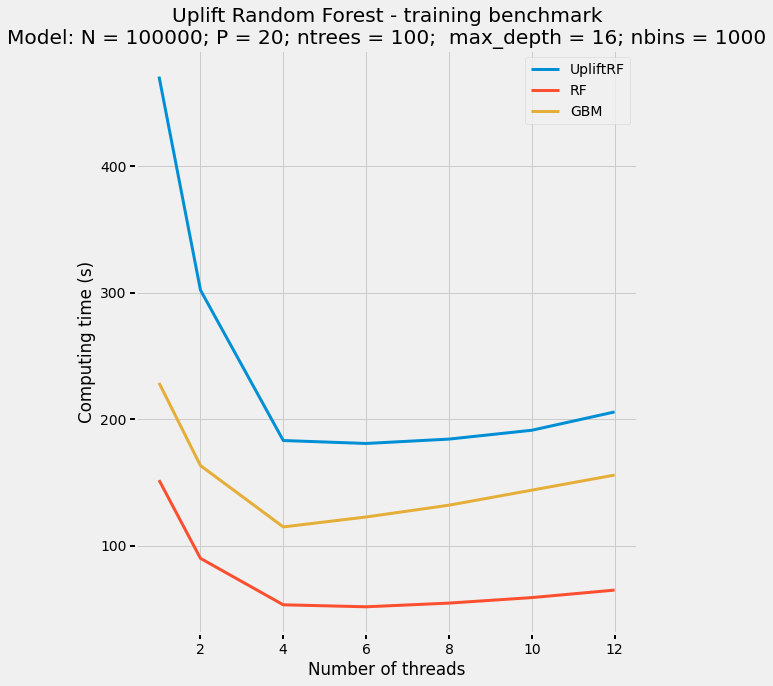

In [10]:
plot_result(uplift_time8, rf_time8, gbm_time8)

### Bigger sample_size

In [11]:
N = 100000
P = 20
max_depth = max_depths[2]
print(f"max_depth = {max_depth}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

max_depth = 20


In [12]:
uplift_time9, rf_time9, gbm_time9 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpohbgs5rr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpohbgs5rr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpohbgs5rr\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,11 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_1kgzdx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.60356974601746s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.04553079605103s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 280.89257764816284s
H2O session _sid_921f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppfw6d29i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppfw6d29i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppfw6d29i\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_jhfkgv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 318.69269609451294s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.07411503791809s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 280.54747223854065s
H2O session _sid_86a7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoh4gg_d1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoh4gg_d1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoh4gg_d1\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_r1ni8d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.46032643318176s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.0405158996582s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 282.45162200927734s
H2O session _sid_8328 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmhhrxb5w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmhhrxb5w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmhhrxb5w\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_nnc01p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.1490669250488s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.71832013130188s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 280.95670914649963s
H2O session _sid_87c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkklxszra
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkklxszra\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkklxszra\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 39 minutes
H2O_cluster_name:,H2O_from_python_potte_qn9mu1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 316.8894991874695s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 76.79124045372009s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 282.70025062561035s
H2O session _sid_b7f5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpycgp767r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpycgp767r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpycgp767r\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,12 hours and 51 minutes
H2O_cluster_name:,H2O_from_python_potte_657bz1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 316.32800459861755s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 74.57758212089539s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 282.3554799556732s
H2O session _sid_b6b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx3e9sso_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx3e9sso_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx3e9sso_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 2 minutes
H2O_cluster_name:,H2O_from_python_potte_0djiuw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 316.25296545028687s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.52327227592468s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 282.90084528923035s
H2O session _sid_93e2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpchi8tlvz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpchi8tlvz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpchi8tlvz\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_potte_9ztjwb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 315.36199378967285s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.07250905036926s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 282.60180616378784s
H2O session _sid_8196 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5zne7im9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5zne7im9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5zne7im9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_xbswbt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 314.9129798412323s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 75.63507175445557s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 280.7229595184326s
H2O session _sid_8efd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeycizokz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeycizokz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeycizokz\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_os2np2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 315.19526839256287s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 77.35577964782715s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 280.5837354660034s
H2O session _sid_b7e1 closed.
Uplift 316.5846370458603s
RF 75.88339371681214s
gbm 281.67134580612185s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbdssanlf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbdssanlf\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,13 hours and 49 minutes
H2O_cluster_name:,H2O_from_python_potte_zgaium
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.92817211151123s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 72.22243332862854s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 258.689453125s
H2O session _sid_a9d8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphm_cs8_5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphm_cs8_5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphm_cs8_5\h2o_potte_started_from_python.err
 

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours
H2O_cluster_name:,H2O_from_python_potte_fif2ls
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.69250893592834s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.41872525215149s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 259.93161821365356s
H2O session _sid_9015 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpecrc6xtp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpecrc6xtp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpecrc6xtp\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 10 minutes
H2O_cluster_name:,H2O_from_python_potte_bfapjq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 291.3100447654724s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.34403944015503s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 259.41006875038147s
H2O session _sid_8f92 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdo6vzql6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdo6vzql6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdo6vzql6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 21 minutes
H2O_cluster_name:,H2O_from_python_potte_9j12gy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.59682178497314s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.40670776367188s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 259.54834508895874s
H2O session _sid_916e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8nhf9s_4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8nhf9s_4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8nhf9s_4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_9z7zw6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 292.6378712654114s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.14624524116516s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 258.5816342830658s
H2O session _sid_886e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxeqmf35_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxeqmf35_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxeqmf35_\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 43 minutes
H2O_cluster_name:,H2O_from_python_potte_jkrlm9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 291.474308013916s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 69.43741393089294s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 256.59153628349304s
H2O session _sid_9f54 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp22mahezj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp22mahezj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp22mahezj\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,14 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_o0flpd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 289.718469619751s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.5543360710144s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 260.66077160835266s
H2O session _sid_8967 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvoay1vxl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvoay1vxl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvoay1vxl\h2o_potte_started_from_python.err

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_im3veg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.3866295814514s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.30584192276001s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 258.0383393764496s
H2O session _sid_9744 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb42yk6gm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb42yk6gm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb42yk6gm\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 15 minutes
H2O_cluster_name:,H2O_from_python_potte_anqmv0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.3380060195923s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.46148824691772s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 259.268607378006s
H2O session _sid_bb24 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7hxdpo8r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7hxdpo8r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7hxdpo8r\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 26 minutes
H2O_cluster_name:,H2O_from_python_potte_axj5sg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 292.54599261283875s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 70.51807451248169s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 258.92228651046753s
H2O session _sid_945a closed.
Uplift 292.5628824710846s
RF 70.48153057098389s
gbm 258.96426606178284s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0nct1axr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0nct1axr\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_d45jb3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 280.2192118167877s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.62359189987183s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 232.11911129951477s
H2O session _sid_86b3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_zeobtq9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_zeobtq9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_zeobtq9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_ot60ia
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 281.89108061790466s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.75695753097534s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.28465819358826s
H2O session _sid_84ae closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsbc10jq4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsbc10jq4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsbc10jq4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,15 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_569s79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 282.71162128448486s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.34877061843872s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 236.49984765052795s
H2O session _sid_8c98 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpziva6jh9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpziva6jh9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpziva6jh9\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_u7iu3f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 284.31944394111633s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.57412934303284s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.98088216781616s
H2O session _sid_b308 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpenxeou1n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpenxeou1n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpenxeou1n\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_x4sgm6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 282.65780329704285s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.66489958763123s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 240.02014470100403s
H2O session _sid_a814 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvuw1fm3w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvuw1fm3w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvuw1fm3w\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 27 minutes
H2O_cluster_name:,H2O_from_python_potte_oaafhu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 282.62352228164673s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.52456545829773s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.12495589256287s
H2O session _sid_81a2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplcj42d4z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplcj42d4z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplcj42d4z\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_tzkung
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 281.8591594696045s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.55366826057434s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 234.24410462379456s
H2O session _sid_86ad closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq_fz1y5m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq_fz1y5m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq_fz1y5m\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 48 minutes
H2O_cluster_name:,H2O_from_python_potte_2w7m3i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 283.31598711013794s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.7402970790863s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.34339690208435s
H2O session _sid_bb7a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp86a2csk3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp86a2csk3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp86a2csk3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,16 hours and 58 minutes
H2O_cluster_name:,H2O_from_python_potte_qg4zrc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 284.6189560890198s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.72934031486511s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 233.41465759277344s
H2O session _sid_be0b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpywu5iqqk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpywu5iqqk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpywu5iqqk\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 8 minutes
H2O_cluster_name:,H2O_from_python_potte_wrah9q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 284.0145618915558s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 65.61745429039001s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 232.99751210212708s
H2O session _sid_b106 closed.
Uplift 282.8231347799301s
RF 65.51336743831635s
gbm 236.00292711257936s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo1izxfo8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo1izxfo8\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_vjcigo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 272.2408273220062s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 62.13350987434387s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.21444606781006s
H2O session _sid_a957 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqsj2ww2g
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqsj2ww2g\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqsj2ww2g\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_enz85b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 275.78930163383484s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.36997413635254s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.25678300857544s
H2O session _sid_a783 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp40x1jedq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp40x1jedq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp40x1jedq\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 37 minutes
H2O_cluster_name:,H2O_from_python_potte_5rn90g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.92126083374023s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 59.94345474243164s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.4392125606537s
H2O session _sid_b302 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5y5yocdr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5y5yocdr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5y5yocdr\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 47 minutes
H2O_cluster_name:,H2O_from_python_potte_yz4d9x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.9884753227234s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.99165368080139s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.89382410049438s
H2O session _sid_9624 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd_pkxera
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd_pkxera\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd_pkxera\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,17 hours and 57 minutes
H2O_cluster_name:,H2O_from_python_potte_avq6zc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 272.8717141151428s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 60.403663873672485s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.12198114395142s
H2O session _sid_9d71 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp846ajsxx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp846ajsxx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp846ajsxx\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 6 minutes
H2O_cluster_name:,H2O_from_python_potte_zmulnq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 274.5208501815796s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.41051745414734s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.71802854537964s
H2O session _sid_89f2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp00wxbjq3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp00wxbjq3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp00wxbjq3\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 16 minutes
H2O_cluster_name:,H2O_from_python_potte_i4z278
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 269.4592332839966s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.496291160583496s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 221.82731080055237s
H2O session _sid_a630 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz_wb9x8x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz_wb9x8x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz_wb9x8x\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 25 minutes
H2O_cluster_name:,H2O_from_python_potte_n0bk6s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 270.62402749061584s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.29475402832031s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.20792841911316s
H2O session _sid_8070 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3l019ybw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3l019ybw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3l019ybw\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 35 minutes
H2O_cluster_name:,H2O_from_python_potte_l41ohb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.89616537094116s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.12730836868286s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 220.0094175338745s
H2O session _sid_bb10 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfmzgatv8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfmzgatv8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfmzgatv8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 45 minutes
H2O_cluster_name:,H2O_from_python_potte_ljx737
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.7698404788971s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 61.98592138290405s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.31030368804932s
H2O session _sid_b99f closed.
Uplift 272.00816960334777s
RF 61.315704870223996s
gbm 221.3999235868454s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfe_2mfq8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfe_2mfq8\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,18 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_8bd5pz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 269.70760893821716s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.571231842041016s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 204.2030212879181s
H2O session _sid_bafb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpykndsqc5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpykndsqc5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpykndsqc5\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 4 minutes
H2O_cluster_name:,H2O_from_python_potte_aywuqu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.12438774108887s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.171469926834106s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 204.14835786819458s
H2O session _sid_9f6d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptx71vzrg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptx71vzrg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptx71vzrg\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 13 minutes
H2O_cluster_name:,H2O_from_python_potte_zfmdn8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 268.50296115875244s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.5655038356781s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 204.02097511291504s
H2O session _sid_a591 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvysn_b0s
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvysn_b0s\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvysn_b0s\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 22 minutes
H2O_cluster_name:,H2O_from_python_potte_4ukp15
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 272.3973271846771s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.21131348609924s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 199.31371355056763s
H2O session _sid_828b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxih8v90e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxih8v90e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxih8v90e\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_jsio3m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 266.1401860713959s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.55934381484985s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 200.8600046634674s
H2O session _sid_a0a4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6pcnzkye
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6pcnzkye\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6pcnzkye\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_potte_t4hhfb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.9585852622986s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.52995729446411s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.16484093666077s
H2O session _sid_96bd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpia02_tpe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpia02_tpe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpia02_tpe\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,19 hours and 50 minutes
H2O_cluster_name:,H2O_from_python_potte_zn6g2f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 269.5253026485443s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.50764465332031s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 203.04665541648865s
H2O session _sid_9d4d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5k8rc77w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5k8rc77w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5k8rc77w\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours
H2O_cluster_name:,H2O_from_python_potte_dxc21z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 267.4323682785034s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.516966581344604s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 201.86867666244507s
H2O session _sid_a33e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzege061h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzege061h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzege061h\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 9 minutes
H2O_cluster_name:,H2O_from_python_potte_kbokmo
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 271.09867787361145s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 64.58903312683105s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 202.24587988853455s
H2O session _sid_a63d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_pryx79d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_pryx79d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_pryx79d\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 18 minutes
H2O_cluster_name:,H2O_from_python_potte_fpmsdu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 270.20579719543457s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 63.30383372306824s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 202.59471940994263s
H2O session _sid_a3bc closed.
Uplift 269.4093202352524s
RF 63.85262982845306s
gbm 202.84668447971345s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoc3hjo75
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoc3hjo75\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 28 minutes
H2O_cluster_name:,H2O_from_python_potte_fbssso
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 380.7009205818176s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.85088896751404s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 246.0912275314331s
H2O session _sid_8353 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm4dg812e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm4dg812e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm4dg812e\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 40 minutes
H2O_cluster_name:,H2O_from_python_potte_6j5b7p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 382.1932165622711s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.92869472503662s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 242.7924268245697s
H2O session _sid_bc57 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfjvjcr2p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfjvjcr2p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfjvjcr2p\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,20 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_3gey43
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 383.9971442222595s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 95.93160271644592s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.0127968788147s
H2O session _sid_b91b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpknmafqn7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpknmafqn7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpknmafqn7\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 5 minutes
H2O_cluster_name:,H2O_from_python_potte_y0jy37
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 382.34115862846375s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 96.23146629333496s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.77002620697021s
H2O session _sid_a52b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwdy5weyq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwdy5weyq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwdy5weyq\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 17 minutes
H2O_cluster_name:,H2O_from_python_potte_pj9g6z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 376.98790740966797s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.99344325065613s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.1209044456482s
H2O session _sid_8e91 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpv6yxbqpp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpv6yxbqpp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpv6yxbqpp\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 30 minutes
H2O_cluster_name:,H2O_from_python_potte_3w20od
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 379.88162207603455s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.92623829841614s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 243.68571209907532s
H2O session _sid_9779 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpyzo43v31
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpyzo43v31\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpyzo43v31\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 42 minutes
H2O_cluster_name:,H2O_from_python_potte_irg7aw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 382.25661873817444s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.74750924110413s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 242.6438283920288s
H2O session _sid_9151 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpm7062kzm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpm7062kzm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpm7062kzm\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,21 hours and 54 minutes
H2O_cluster_name:,H2O_from_python_potte_vu1zqa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 381.0840685367584s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.84057974815369s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.42945742607117s
H2O session _sid_9596 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwai64rd9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwai64rd9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwai64rd9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 7 minutes
H2O_cluster_name:,H2O_from_python_potte_3dsywj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 381.32713651657104s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.86222863197327s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 241.87295293807983s
H2O session _sid_8d5d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1p880veg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1p880veg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1p880veg\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 19 minutes
H2O_cluster_name:,H2O_from_python_potte_fkww8a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 383.77935314178467s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 94.69175791740417s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 242.33900117874146s
H2O session _sid_bfe5 closed.
Uplift 381.4549146413803s
RF 94.4004409790039s
gbm 243.27583339214326s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_rwo3bui
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_rwo3bui\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 32 minutes
H2O_cluster_name:,H2O_from_python_potte_upl3xj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 653.146642446518s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 179.00026082992554s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 369.752729177475s
H2O session _sid_b959 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2zreozu2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2zreozu2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2zreozu2\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,22 hours and 52 minutes
H2O_cluster_name:,H2O_from_python_potte_i5lidz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 654.1024262905121s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 181.03068447113037s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 359.09877467155457s
H2O session _sid_8c09 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx29axady
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx29axady\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx29axady\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 12 minutes
H2O_cluster_name:,H2O_from_python_potte_d9ptlf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 644.4328575134277s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 177.07211327552795s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 375.13616967201233s
H2O session _sid_bf69 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpygr3zx7j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpygr3zx7j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpygr3zx7j\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 33 minutes
H2O_cluster_name:,H2O_from_python_potte_dk11ub
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 644.3956253528595s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 178.84103059768677s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 376.22247552871704s
H2O session _sid_bdf8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplagfqa44
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplagfqa44\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplagfqa44\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,23 hours and 53 minutes
H2O_cluster_name:,H2O_from_python_potte_iowyhx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 651.3274431228638s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 178.60094904899597s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 366.6030776500702s
H2O session _sid_955a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5w0tfflg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5w0tfflg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5w0tfflg\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_43y2mg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 658.7461583614349s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 181.2799379825592s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 374.1082260608673s
H2O session _sid_b64a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptcobrvku
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptcobrvku\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptcobrvku\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4x6o1h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 654.3058104515076s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 178.59541249275208s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 367.2118911743164s
H2O session _sid_af6e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt2rausca
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt2rausca\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt2rausca\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rh5le4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 648.6677775382996s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 178.24031448364258s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 378.3446035385132s
H2O session _sid_b9ca closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9hr8mxw8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9hr8mxw8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9hr8mxw8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_84b5h1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 654.4996056556702s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 178.73225378990173s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 372.709983587265s
H2O session _sid_abcb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5401ohvm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5401ohvm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5401ohvm\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_a627j0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 657.3980791568756s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 176.23854684829712s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 369.2725667953491s
H2O session _sid_a846 closed.
Uplift 652.1022425889969s
RF 178.76315038204194s
gbm 370.846049785614s
12 - Uplift = 316.5846370458603, RF = 75.88339371681214, gbm = 281.67134580612185
10 - Uplift = 292.5628824710846, RF = 70.48153057098389, gbm = 258.96426606178284
8 - Uplift = 282.8231347799301, RF = 65.51336743831635, gbm = 236.00292711257936
6 - Uplift = 272.00816960334777, RF = 61.315704870223996, gbm = 221.3999235868454
4 - Uplift = 269.4093202352524, RF = 63.85262982845306, gbm = 202.84668447971345
2 - Uplift = 381.4549

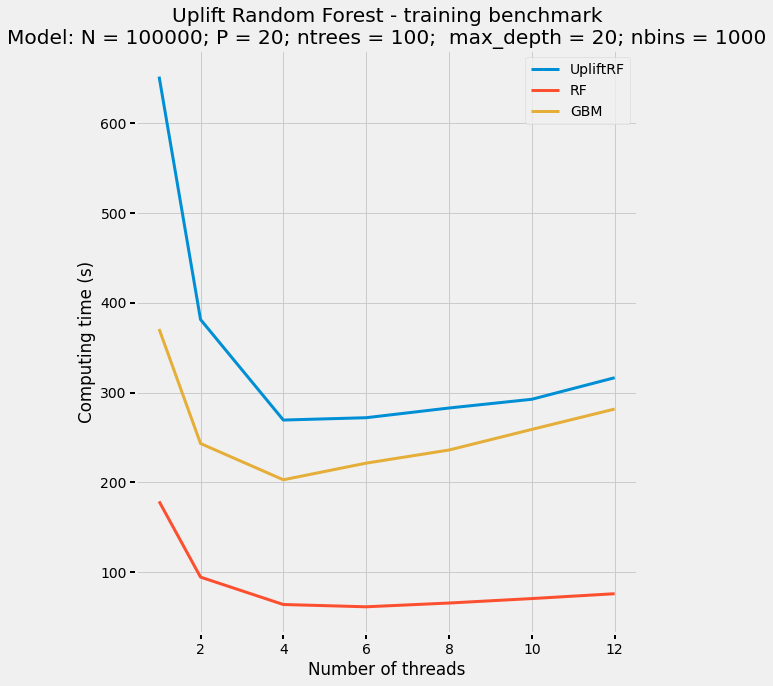

In [13]:
plot_result(uplift_time9, rf_time9, gbm_time9)

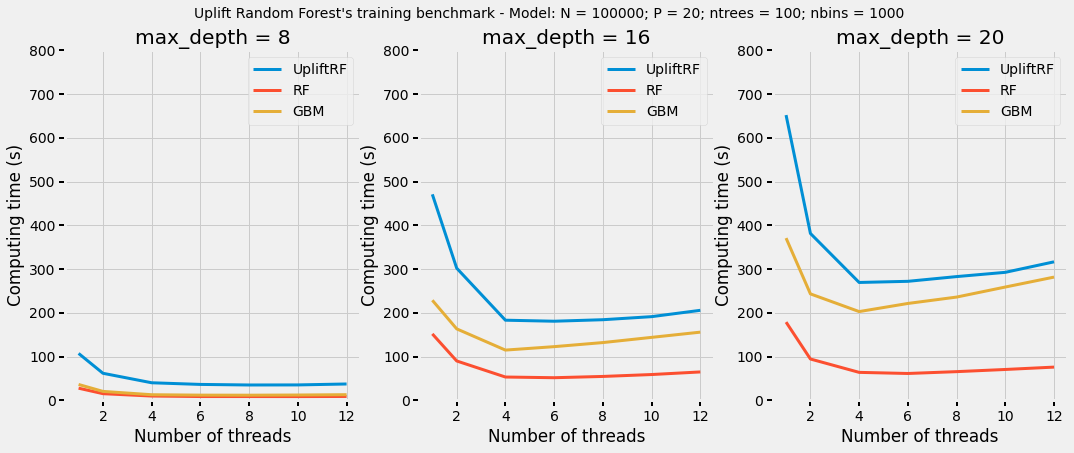

In [14]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf = [rf_time7, rf_time8, rf_time9]
all_predict_gbm = [gbm_time7, gbm_time8, gbm_time9]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM", linewidth=3)     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 800)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [15]:
print(all_predict_uplift)

[{12: 37.29973356723785, 10: 35.16867716312409, 8: 35.005666971206665, 6: 36.30608079433441, 4: 40.08041524887085, 2: 61.77351982593537, 1: 107.16136739253997}, {12: 205.72789561748505, 10: 191.23674490451813, 8: 184.24479706287383, 6: 180.78782126903533, 4: 183.12389061450958, 2: 302.094970202446, 1: 470.89915549755096}, {12: 316.5846370458603, 10: 292.5628824710846, 8: 282.8231347799301, 6: 272.00816960334777, 4: 269.4093202352524, 2: 381.4549146413803, 1: 652.1022425889969}]


In [16]:
print(all_predict_rf)

[{12: 8.773268175125121, 10: 8.511157393455505, 8: 8.590010619163513, 6: 8.620383262634277, 4: 9.732961058616638, 2: 15.15018675327301, 1: 27.688566184043886}, {12: 64.84183049201965, 10: 58.90531902313232, 8: 54.550091886520384, 6: 51.63365905284881, 4: 53.20532913208008, 2: 89.94360516071319, 1: 151.81486871242524}, {12: 75.88339371681214, 10: 70.48153057098389, 8: 65.51336743831635, 6: 61.315704870223996, 4: 63.85262982845306, 2: 94.4004409790039, 1: 178.76315038204194}]


In [17]:
print(all_predict_gbm)

[{12: 12.842734479904175, 10: 12.082276439666748, 8: 11.675499629974365, 6: 11.81721751689911, 4: 12.742917442321778, 2: 20.34330825805664, 1: 36.17499415874481}, {12: 155.81167402267457, 10: 143.86941921710968, 8: 131.98002371788024, 6: 122.65248744487762, 4: 114.79902944564819, 2: 163.32140955924987, 1: 228.7018667459488}, {12: 281.67134580612185, 10: 258.96426606178284, 8: 236.00292711257936, 6: 221.3999235868454, 4: 202.84668447971345, 2: 243.27583339214326, 1: 370.846049785614}]


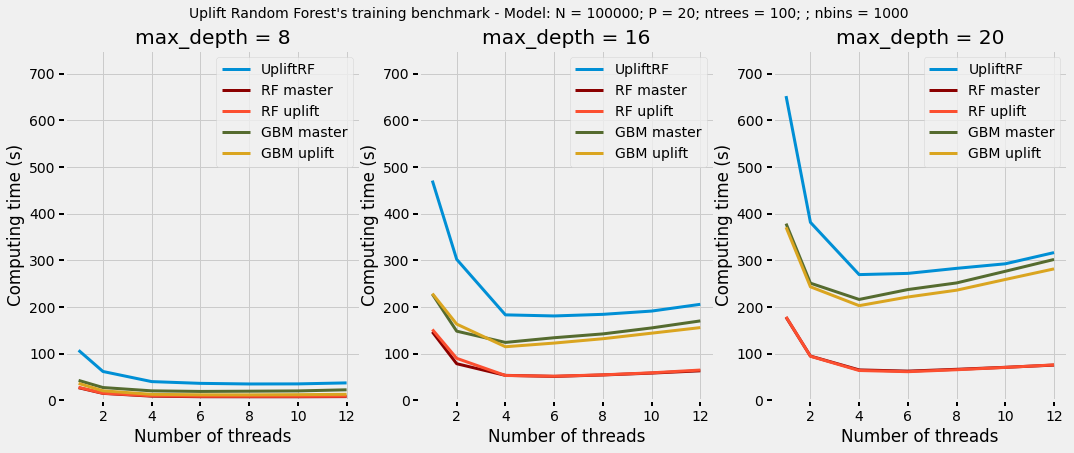

In [18]:
all_predict_uplift = [uplift_time7, uplift_time8, uplift_time9]
all_predict_rf_uplift = [rf_time7, rf_time8, rf_time9]
all_predict_gbm_uplift = [gbm_time7, gbm_time8, gbm_time9]
all_predict_gbm_master = [{12: 22.480031037330626, 10: 20.100569820404054, 8: 19.50397570133209, 6: 19.02869620323181, 4: 20.260752630233764, 2: 27.356335163116455, 1: 42.66778080463409}, {12: 170.18061714172364, 10: 155.1232393026352, 8: 142.310054397583, 6: 134.1138013601303, 4: 124.05112998485565, 2: 148.1445460319519, 1: 227.6855852842331}, {12: 301.867510843277, 10: 276.53642892837524, 8: 251.56781561374663, 6: 237.37603039741515, 4: 216.16113529205322, 2: 251.0626908302307, 1: 378.6919209241867}]
all_predict_rf_master = [{12: 7.952457348505656, 10: 7.589529991149902, 8: 7.599389672279358, 6: 7.7046345472335815, 4: 8.885488470395407, 2: 14.876623670260111, 1: 26.981343309084576}, {12: 63.210454185803734, 10: 58.30900597572327, 8: 54.306622544924416, 6: 51.23956127961477, 4: 53.46246202786764, 2: 78.41126509507497, 1: 146.63578669230142}, {12: 75.49273610115051, 10: 70.69829328854878, 8: 66.41124494870503, 6: 62.54522828261057, 4: 65.12324817975362, 2: 94.78704722722371, 1: 178.1989031235377}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; ; nbins = {nbins}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(max_depths) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color="darkolivegreen")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")     
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 750)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"max_depth = {max_depths[i - 1]}")

plt.savefig(f"h2o-train-perf-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [19]:
N = 100000
P = 20
max_depth = 16
nbins=nbinss[0]
print(f"nbins = {nbins}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

nbins = 20


In [20]:
uplift_time0, rf_time0, gbm_time0 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp_8ns6ox
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp_8ns6ox\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp_8ns6ox\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_g3q7sp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.64707612991333s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.695359468460083s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.792611360549927s
H2O session _sid_9d10 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmn2p0v85
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmn2p0v85\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmn2p0v85\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kfaz3f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.101757287979126s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.980561017990112s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.042920112609863s
H2O session _sid_bfa5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmph82p8tci
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmph82p8tci\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmph82p8tci\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qtghfy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.28358793258667s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.459282398223877s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.843253135681152s
H2O session _sid_a9d9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpt6dyxzfj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpt6dyxzfj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpt6dyxzfj\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mco7et
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.257328033447266s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.705732107162476s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.876776695251465s
H2O session _sid_8bcb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjw6bxj58
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjw6bxj58\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjw6bxj58\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jydlii
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.208473682403564s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.91735076904297s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.842612743377686s
H2O session _sid_96e6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0amn2khg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0amn2khg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0amn2khg\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_x1ql8j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.90915060043335s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.798047065734863s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.66965413093567s
H2O session _sid_8686 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_q2sn4kz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_q2sn4kz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_q2sn4kz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tduta0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.70104718208313s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.96029543876648s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.01353406906128s
H2O session _sid_9e98 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeipn8are
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeipn8are\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeipn8are\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nnfq5p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.27418613433838s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.70612645149231s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.562231063842773s
H2O session _sid_837e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnyp3laph
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnyp3laph\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnyp3laph\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_89k5uj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.36484169960022s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.00924515724182s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.68105173110962s
H2O session _sid_be35 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppof2qi_w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppof2qi_w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppof2qi_w\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_shbh2u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.87003684043884s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.874626398086548s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.65543031692505s
H2O session _sid_a80f closed.
Uplift 45.76174855232239s
RF 17.910662627220155s
gbm 23.398007535934447s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjx2vjqut
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjx2vjqut\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ktze6h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.57194471359253s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.004374742507935s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.69580316543579s
H2O session _sid_850a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpr05mk_f9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpr05mk_f9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpr05mk_f9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dkvhnb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.40287923812866s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.222410917282104s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.594285249710083s
H2O session _sid_aacc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8bn9jxe0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8bn9jxe0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8bn9jxe0\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xw26rw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.93025183677673s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.517738580703735s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.46195340156555s
H2O session _sid_bb03 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5d95jito
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5d95jito\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5d95jito\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pftlze
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.76325225830078s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.583736658096313s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.862262964248657s
H2O session _sid_bf8b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpod9803w_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpod9803w_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpod9803w_\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2chklr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.913814544677734s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.13821578025818s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.590490579605103s
H2O session _sid_9bf5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcn2mneh2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcn2mneh2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcn2mneh2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_s7yvaz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.95771050453186s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.619192123413086s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.726428031921387s
H2O session _sid_8776 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzp24v85w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzp24v85w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzp24v85w\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1si8p1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.924805879592896s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.28590488433838s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.367625951766968s
H2O session _sid_b61a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpye8bl67t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpye8bl67t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpye8bl67t\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2ta2rg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.14401721954346s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.4746515750885s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.47981882095337s
H2O session _sid_9d2f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsf2lp9v7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsf2lp9v7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsf2lp9v7\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6ixi8i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 43.96040368080139s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.506293535232544s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.284331798553467s
H2O session _sid_94e4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxizs76x4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxizs76x4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxizs76x4\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xyh1xw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.75350475311279s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.653748989105225s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.701240301132202s
H2O session _sid_b543 closed.
Uplift 44.832258462905884s
RF 17.8006267786026s
gbm 22.97642402648926s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3fogmac_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3fogmac_\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_u3izs9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.66292762756348s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.031153202056885s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.289249658584595s
H2O session _sid_98e2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp08drq5e
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp08drq5e\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp08drq5e\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zr9z55
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.84549427032471s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.477766036987305s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.604535818099976s
H2O session _sid_8375 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkvfdde5l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkvfdde5l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkvfdde5l\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bve42r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.76548171043396s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.406931161880493s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.57283115386963s
H2O session _sid_a1af closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwxb1puh8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwxb1puh8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwxb1puh8\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lwv5zz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.328624963760376s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.367793321609497s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.544734954833984s
H2O session _sid_a3db closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_x0xr93a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_x0xr93a\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_x0xr93a\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wx8hkr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 47.27699375152588s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.460662364959717s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.453806161880493s
H2O session _sid_aaa5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp3ht0ynp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp3ht0ynp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp3ht0ynp\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qn8j86
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.90135455131531s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.315697193145752s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.49321413040161s
H2O session _sid_b6c8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc2mi5cea
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc2mi5cea\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc2mi5cea\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0lhry7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.714211225509644s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.271586179733276s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.49924373626709s
H2O session _sid_b7d2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp0uamx1fk
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp0uamx1fk\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp0uamx1fk\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_doural
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.718655586242676s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.24928307533264s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.56580638885498s
H2O session _sid_a696 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_f1pkxdb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_f1pkxdb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_f1pkxdb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0dctkd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.00326132774353s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.133015155792236s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.51824641227722s
H2O session _sid_ad94 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8djywtoi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8djywtoi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8djywtoi\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_phgepf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 44.36683511734009s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 17.341934204101562s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 21.77176523208618s
H2O session _sid_a9ce closed.
Uplift 45.05838401317597s
RF 17.905582189559937s
gbm 22.431343364715577s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9imb7yh3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9imb7yh3\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_y5pimn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.2912073135376s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.218887090682983s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.689139127731323s
H2O session _sid_b378 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjm_613tl
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjm_613tl\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjm_613tl\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xirrdg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.286930561065674s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.49779963493347s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.869903802871704s
H2O session _sid_b9ee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgsve2a1i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgsve2a1i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgsve2a1i\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9uavvw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.01337814331055s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.27323269844055s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.00708293914795s
H2O session _sid_8ec8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9gnlg7s8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9gnlg7s8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9gnlg7s8\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_11euf0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.279069900512695s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.52370595932007s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.669936180114746s
H2O session _sid_a977 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3k204cmh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3k204cmh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3k204cmh\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_krt7qk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.20509052276611s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.401607513427734s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 23.457002878189087s
H2O session _sid_9cf9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsl5g6934
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsl5g6934\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsl5g6934\h2o_potte_started_from_python.

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uuslao
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.53736639022827s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.31628966331482s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.70898747444153s
H2O session _sid_aab3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp14_ogvpm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp14_ogvpm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp14_ogvpm\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rycgux
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.244773864746094s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.48018503189087s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.844960927963257s
H2O session _sid_9044 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqsttsfhu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqsttsfhu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqsttsfhu\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o7cv44
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.824357748031616s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 18.62402653694153s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.914446592330933s
H2O session _sid_9ca7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpun_4tevu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpun_4tevu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpun_4tevu\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_w5dalv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 45.249823808670044s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 19.33544635772705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.931904315948486s
H2O session _sid_a212 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdg4oapc3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdg4oapc3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdg4oapc3\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tu3eua
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 46.53719186782837s
drf Model Build progress: |███████████████████████████████████████████████████████| (done) 100%
RF Time: 19.36955237388611s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 22.888696908950806s
H2O session _sid_b569 closed.
Uplift 45.6469190120697s
RF 18.90407328605652s
gbm 22.998206114768983s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjsbwu5_2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjsbwu5_2\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rgn6sq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.694212913513184s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.810535669326782s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.980034589767456s
H2O session _sid_a4a4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy80bqsof
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy80bqsof\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy80bqsof\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_kztkwb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.83979392051697s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.834314823150635s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.957634449005127s
H2O session _sid_a6bb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3voulskj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3voulskj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3voulskj\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qe57he
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.56975483894348s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.87068510055542s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.991098642349243s
H2O session _sid_baee closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprutg669i
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprutg669i\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprutg669i\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_iqzsgy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.49701380729675s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.81464695930481s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.06159234046936s
H2O session _sid_98ef closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf6wddnx2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf6wddnx2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf6wddnx2\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2k0he7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.567397117614746s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.866440773010254s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.049395084381104s
H2O session _sid_8cb1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpci3fzp8o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpci3fzp8o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpci3fzp8o\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7z8sl7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.588683128356934s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.933353424072266s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.126911878585815s
H2O session _sid_9ef8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_s6h3n8l
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_s6h3n8l\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_s6h3n8l\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4hs4ra
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.593531131744385s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.956570386886597s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.885941743850708s
H2O session _sid_8b41 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg_w1w6r8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg_w1w6r8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg_w1w6r8\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4ege3t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.4179949760437s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.945685148239136s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.97411584854126s
H2O session _sid_bb92 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpiodk3y0j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpiodk3y0j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpiodk3y0j\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xdssz4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.38232111930847s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 23.151018142700195s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 26.181957721710205s
H2O session _sid_b202 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpf5xr3vh6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpf5xr3vh6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpf5xr3vh6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dndnt1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 51.573628187179565s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 21.791365146636963s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 25.959847450256348s
H2O session _sid_a365 closed.
Uplift 51.57243311405182s
RF 21.997461557388306s
gbm 26.016852974891663s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmponz2ydfs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmponz2ydfs\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0oj797
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 75.19971919059753s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.97209119796753s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.608147382736206s
H2O session _sid_8dfa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxj48fagj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxj48fagj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxj48fagj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tm25hh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.14488172531128s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.07806658744812s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.37647032737732s
H2O session _sid_ac44 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmptah4i4aa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmptah4i4aa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmptah4i4aa\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wfnu62
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 75.86611914634705s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.95867967605591s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.74189901351929s
H2O session _sid_be25 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp61vxfgo0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp61vxfgo0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp61vxfgo0\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1qlw9u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 73.77195405960083s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.94554257392883s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.54651713371277s
H2O session _sid_8402 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzhpo9xlg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzhpo9xlg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzhpo9xlg\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_jqd9c6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 76.31901979446411s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.22734999656677s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.41447639465332s
H2O session _sid_9301 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4xxiselb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4xxiselb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4xxiselb\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_p5ga2w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.95520663261414s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.23034071922302s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.846585512161255s
H2O session _sid_9228 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd2s1x4dw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd2s1x4dw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd2s1x4dw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_syhs30
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.91393208503723s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.04035186767578s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.109928369522095s
H2O session _sid_a3dd closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpasburo_b
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpasburo_b\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpasburo_b\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5srdzn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 75.24852991104126s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.18858075141907s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.50719881057739s
H2O session _sid_a13e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplbjnk94p
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplbjnk94p\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplbjnk94p\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lhh8q2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.64454674720764s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.118340730667114s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 40.734313011169434s
H2O session _sid_b31e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmdr7kqho
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmdr7kqho\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmdr7kqho\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zpnfqy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 74.12020564079285s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.29343223571777s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 41.25895619392395s
H2O session _sid_9fe9 closed.
Uplift 74.91841149330139s
RF 35.50527763366699s
gbm 40.8144492149353s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_vuc2o1u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_vuc2o1u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ql7oyt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.65906000137329s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.35505676269531s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.51940512657166s
H2O session _sid_91e4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7_69zq9y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7_69zq9y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7_69zq9y\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_t5yx5u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.85141515731812s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.52350044250488s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.92341995239258s
H2O session _sid_9927 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsrgme57u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsrgme57u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsrgme57u\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uxfanh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.30059099197388s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.83997011184692s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.83075284957886s
H2O session _sid_a920 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoelxhlbw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoelxhlbw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoelxhlbw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dr84ru
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 120.47030997276306s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.44899392127991s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.27725648880005s
H2O session _sid_a5d7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpta84nho9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpta84nho9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpta84nho9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tqstd3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 117.83937382698059s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.32649803161621s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.94228672981262s
H2O session _sid_96c8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfmdpmppd
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfmdpmppd\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfmdpmppd\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wz3z91
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.56291508674622s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.72662734985352s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 69.99825620651245s
H2O session _sid_aac1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdqf_5lwf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdqf_5lwf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdqf_5lwf\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0rx407
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.01012182235718s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.16446900367737s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.99526786804199s
H2O session _sid_84dc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7xubiudq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7xubiudq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7xubiudq\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rpwuc0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 120.23600244522095s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 66.59280467033386s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.61858820915222s
H2O session _sid_a7ad closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy5n1zjci
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy5n1zjci\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy5n1zjci\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_i1o3ut
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 121.76151442527771s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.71184396743774s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.30851292610168s
H2O session _sid_806a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps2xrwm0c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps2xrwm0c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps2xrwm0c\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nd0q8z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 119.65637946128845s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 67.41170859336853s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.91215324401855s
H2O session _sid_968d closed.
Uplift 119.93476831912994s
RF 67.41014728546142s
gbm 71.03258996009826s
12 - Uplift = 45.76174855232239, RF = 17.910662627220155, gbm = 23.398007535934447
10 - Uplift = 44.832258462905884, RF = 17.8006267786026, gbm = 22.97642402648926
8 - Uplift = 45.05838401317597, RF = 17.905582189559937, gbm = 22.431343364715577
6 - Uplift = 45.6469190120697, RF = 18.90407328605652, gbm = 22.998206114768983
4 - Uplift = 51.57243311405182, RF = 21.997461557388306, gbm = 26.016852974891663
2 - Uplift = 74.9184

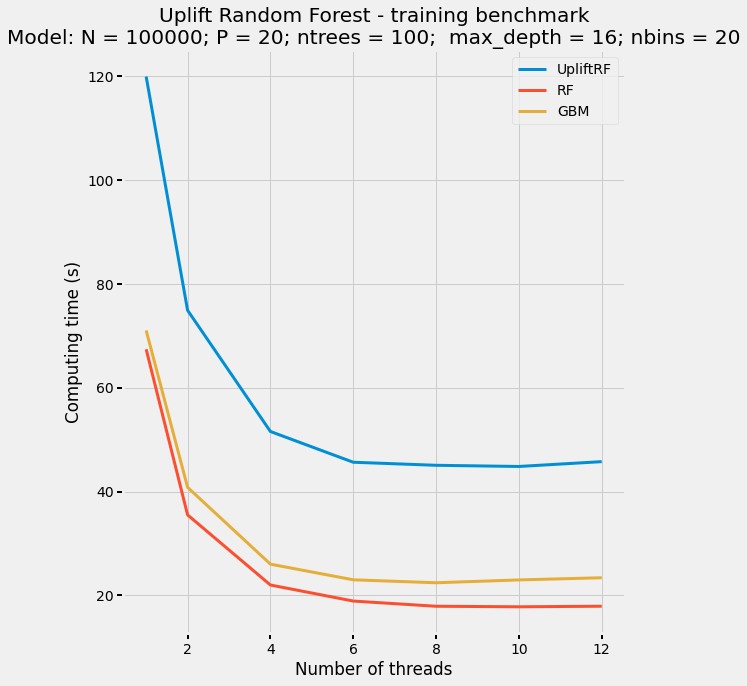

In [21]:
plot_result(uplift_time0, rf_time0, gbm_time0)

In [22]:
N = 100000
P = 20
max_depth = 16
nbins=nbinss[1]
print(f"nbins = {nbins}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

nbins = 400


In [23]:
uplift_time1, rf_time1, gbm_time1 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfx2fsttg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfx2fsttg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfx2fsttg\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_oxvwci
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.42306685447693s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.174516677856445s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.37703013420105s
H2O session _sid_8e12 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc6mln9zf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc6mln9zf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc6mln9zf\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_z9pt4h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 113.12135457992554s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 37.37938952445984s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.87199568748474s
H2O session _sid_a06b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7zjhlims
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7zjhlims\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7zjhlims\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_fv0u2b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.39469957351685s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.86816120147705s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.43760061264038s
H2O session _sid_b533 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6ws09sq1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6ws09sq1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6ws09sq1\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5o1j4v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.10040283203125s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.10498905181885s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 77.26609516143799s
H2O session _sid_ac43 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphqdn7sro
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphqdn7sro\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphqdn7sro\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0n5zyn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.75873851776123s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.630192279815674s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.32327604293823s
H2O session _sid_8485 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpogr_muyc
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpogr_muyc\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpogr_muyc\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4zcume
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 113.3169436454773s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 36.05641007423401s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.20908737182617s
H2O session _sid_8e4e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpadxdrupv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpadxdrupv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpadxdrupv\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_naiahk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.38578009605408s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.78185844421387s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.07580041885376s
H2O session _sid_ac4c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsixdq9gp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsixdq9gp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsixdq9gp\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_n3dsrr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 111.5719485282898s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.945979595184326s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 77.43487668037415s
H2O session _sid_97f8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq116hdsr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq116hdsr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq116hdsr\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uqvf3u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 114.85139751434326s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.48668813705444s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.41316366195679s
H2O session _sid_9288 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7dd2z5uf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7dd2z5uf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7dd2z5uf\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_re5c5a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 112.15190768241882s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.90462374687195s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 79.63184547424316s
H2O session _sid_811c closed.
Uplift 112.20762398242951s
RF 36.033280873298644s
gbm 79.30407712459564s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpj51bmbk8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpj51bmbk8\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_klk4q2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.5281617641449s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.50405263900757s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.56077790260315s
H2O session _sid_94bf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbzw250vq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbzw250vq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbzw250vq\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ekup0m
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.7335319519043s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.21679615974426s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.52452230453491s
H2O session _sid_b10f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpulvbb3eh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpulvbb3eh\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpulvbb3eh\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vulesc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.57481455802917s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.52551341056824s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.41758728027344s
H2O session _sid_b7ca closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpslt9wvme
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpslt9wvme\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpslt9wvme\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_wo7t6b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.6386182308197s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.19808530807495s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.12199091911316s
H2O session _sid_8d14 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwx2hgej4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwx2hgej4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwx2hgej4\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0irecv
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.89593076705933s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.70971179008484s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.83388090133667s
H2O session _sid_9299 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkwvhkl37
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkwvhkl37\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkwvhkl37\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_egcm34
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.28375697135925s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.245445251464844s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.75400018692017s
H2O session _sid_a71c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjtlfuj2z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjtlfuj2z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjtlfuj2z\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_swdn90
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.88231015205383s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.1674690246582s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.42352533340454s
H2O session _sid_a77c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps7mi7nd_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps7mi7nd_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmps7mi7nd_\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nyq3b8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 104.00343751907349s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.55519104003906s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.54643440246582s
H2O session _sid_a837 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpdchvbj0q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpdchvbj0q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpdchvbj0q\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dau6oi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.11474180221558s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.259597301483154s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 70.78889107704163s
H2O session _sid_8e22 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb0p21tev
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb0p21tev\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb0p21tev\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_rgz2pq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.62287759780884s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.20524573326111s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 71.14313793182373s
H2O session _sid_b18a closed.
Uplift 103.92781813144684s
RF 34.058710765838626s
gbm 71.01147482395172s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9vjkx1i8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9vjkx1i8\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8otgzk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.43481254577637s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.921277046203613s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 64.73542666435242s
H2O session _sid_a5cb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphqtdnzge
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphqtdnzge\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphqtdnzge\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nre2lz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.33867073059082s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 33.0018470287323s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.713374376297s
H2O session _sid_a2ec closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmprphnvbgn
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmprphnvbgn\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmprphnvbgn\h2o_potte_started_from_python.err


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_v1auhr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 100.43494200706482s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.12437582015991s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 64.63757753372192s
H2O session _sid_ace2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi7pfrr9n
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi7pfrr9n\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi7pfrr9n\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9azsmk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 100.66708707809448s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.095460653305054s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.83740639686584s
H2O session _sid_a01e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_w_5hqll
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_w_5hqll\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_w_5hqll\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ev1aln
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 99.77451729774475s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.870144844055176s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.59329199790955s
H2O session _sid_91b5 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7c1pbzwa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7c1pbzwa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7c1pbzwa\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0aihmy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.47571611404419s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.960853099822998s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 64.7028706073761s
H2O session _sid_8edc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8zhl39a6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8zhl39a6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8zhl39a6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_vvvx3e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 100.93141484260559s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.09739661216736s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.85652780532837s
H2O session _sid_88c2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7eqt7out
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7eqt7out\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7eqt7out\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xr7ody
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.05409836769104s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.789610862731934s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 64.67174649238586s
H2O session _sid_896e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpshom2sck
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpshom2sck\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpshom2sck\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_l9lo0j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.75367093086243s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.62361717224121s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 65.87295389175415s
H2O session _sid_bd19 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmzhr1o7c
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmzhr1o7c\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmzhr1o7c\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_snhcn6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 100.69009041786194s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 32.03360629081726s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 68.15841794013977s
H2O session _sid_9b74 closed.
Uplift 101.35550203323365s
RF 32.35181894302368s
gbm 65.5779593706131s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjv2p72rf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjv2p72rf\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lp6okz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 100.86839747428894s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.67402410507202s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.457125425338745s
H2O session _sid_842e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzjpn_ac6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzjpn_ac6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzjpn_ac6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0i8uio
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.88583493232727s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.882432222366333s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.127636432647705s
H2O session _sid_bcb0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc2gcmm1r
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc2gcmm1r\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc2gcmm1r\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c4hqaw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.46094131469727s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.768908500671387s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.86313009262085s
H2O session _sid_bc5a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpis6wm5xu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpis6wm5xu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpis6wm5xu\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_tkge2i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.1984794139862s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.54348635673523s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 64.00190615653992s
H2O session _sid_97a3 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpp0j8t5_j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpp0j8t5_j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpp0j8t5_j\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7gopmd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.43706226348877s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.02116370201111s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.6231472492218s
H2O session _sid_abd7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq94q0g6_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq94q0g6_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpq94q0g6_\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ylq6v5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.28074073791504s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.7296781539917s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.51917910575867s
H2O session _sid_8630 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp9m9crlwt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp9m9crlwt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp9m9crlwt\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1cyp74
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 103.81614923477173s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 30.827837705612183s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.42512798309326s
H2O session _sid_abe6 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6xswb_in
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6xswb_in\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6xswb_in\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_m99a78
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.49012732505798s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.88172173500061s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.40060758590698s
H2O session _sid_9750 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpg57zovm6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpg57zovm6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpg57zovm6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_sxf24t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 102.17673778533936s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.782637119293213s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 61.48625111579895s
H2O session _sid_a270 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2bhm1z5q
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2bhm1z5q\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2bhm1z5q\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7oedq0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 101.07240271568298s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 31.75919246673584s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 62.15408110618591s
H2O session _sid_87b3 closed.
Uplift 101.86868731975555s
RF 31.487108206748964s
gbm 62.00581922531128s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnia1so2t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnia1so2t\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9t4g5d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 109.01657390594482s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.959733724594116s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.3763530254364s
H2O session _sid_830d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpvqb9pwwu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpvqb9pwwu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpvqb9pwwu\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_n4qitc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 110.5363781452179s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.208784341812134s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.338783502578735s
H2O session _sid_bb95 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo88_jam2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo88_jam2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo88_jam2\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_3sup16
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.52139663696289s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.05462050437927s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.274537801742554s
H2O session _sid_8ca8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpur10sbva
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpur10sbva\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpur10sbva\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_sp24x6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 106.44078230857849s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.99355173110962s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.36981964111328s
H2O session _sid_8e10 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuanyish9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuanyish9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuanyish9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mghmep
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 108.1517379283905s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 35.64160895347595s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.12025022506714s
H2O session _sid_8962 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk9mk_s5x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk9mk_s5x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk9mk_s5x\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7pzx0a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.67987656593323s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.23949837684631s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 59.436901569366455s
H2O session _sid_863c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy8gwdnwb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy8gwdnwb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy8gwdnwb\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lsq5ux
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 109.31013441085815s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.02908515930176s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.002312421798706s
H2O session _sid_83e2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpe6h07c5y
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpe6h07c5y\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpe6h07c5y\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_w4cv75
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.89078497886658s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.26555275917053s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.11304831504822s
H2O session _sid_8844 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpqht3sws4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpqht3sws4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpqht3sws4\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gvq72d
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.92172503471375s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.04266428947449s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.67394733428955s
H2O session _sid_aae7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5aw0q0ec
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5aw0q0ec\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5aw0q0ec\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_hlfvo0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 107.65180134773254s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 34.18831181526184s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 60.189048528671265s
H2O session _sid_9a54 closed.
Uplift 108.11211912631988s
RF 34.6623411655426s
gbm 60.18950023651123s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1ollw3c3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1ollw3c3\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nznbwx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 169.3390862941742s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.44512581825256s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 80.54035115242004s
H2O session _sid_9b54 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbtdxsdka
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbtdxsdka\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbtdxsdka\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5l3093
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 167.41578245162964s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.454684019088745s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.83698534965515s
H2O session _sid_9cfb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsj60wltz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsj60wltz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsj60wltz\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_dcr0rt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 167.2107436656952s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.18097162246704s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.49594235420227s
H2O session _sid_b766 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo2w5c6xf
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo2w5c6xf\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo2w5c6xf\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5vm3g3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.3394181728363s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.818522691726685s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.57893514633179s
H2O session _sid_a6ac closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp70t_j8rg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp70t_j8rg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp70t_j8rg\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_z95o1o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 169.70727443695068s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.18823266029358s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.98684620857239s
H2O session _sid_bdfb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2enscmzw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2enscmzw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2enscmzw\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_0jl3kk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.50275707244873s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.89494514465332s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.21910214424133s
H2O session _sid_9900 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp__ktj_ej
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp__ktj_ej\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp__ktj_ej\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gpp855
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 169.63686084747314s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 52.9407856464386s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.95436310768127s
H2O session _sid_bd29 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkq2c331v
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkq2c331v\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkq2c331v\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_u0pdun
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 168.14855456352234s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.800861120224s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 83.0129165649414s
H2O session _sid_a07c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpfdaucdyw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpfdaucdyw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpfdaucdyw\h2o_potte_started_from_python.err


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_racuit
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 172.05564212799072s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 53.08124089241028s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 82.30939865112305s
H2O session _sid_a256 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2j73rt51
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2j73rt51\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2j73rt51\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4nfrnh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 169.392639875412s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 54.35151958465576s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 81.54996275901794s
H2O session _sid_b1d5 closed.
Uplift 168.9748759508133s
RF 53.415688920021054s
gbm 81.94848034381866s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpw_j2z3js
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpw_j2z3js\h2o_potte_started_from_python.out
  JVM stderr: C:\User

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_mqm685
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 299.08893752098083s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.03645610809326s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 130.358731508255s
H2O session _sid_a692 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7g20kkw3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7g20kkw3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7g20kkw3\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_a033fz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 300.02365899086s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.19248056411743s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 134.4674789905548s
H2O session _sid_843f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmppwhyzirt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmppwhyzirt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmppwhyzirt\h2o_potte_started_from_python.err


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_coz1rm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 299.1410446166992s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.97872257232666s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 135.99377942085266s
H2O session _sid_afb0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3vpe5ib_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3vpe5ib_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3vpe5ib_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6jcaaa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 298.76747727394104s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.15060949325562s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.3835690021515s
H2O session _sid_836f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp3jj0le3t
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp3jj0le3t\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp3jj0le3t\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_o9rc3n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 299.04053926467896s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.12631464004517s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.66745495796204s
H2O session _sid_a116 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpi468vcjt
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpi468vcjt\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpi468vcjt\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lq0nyz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 294.72991728782654s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.17652034759521s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 133.38700914382935s
H2O session _sid_9d2d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp13vcikeb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp13vcikeb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp13vcikeb\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xwfeey
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 297.51751732826233s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.16416954994202s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 131.00254726409912s
H2O session _sid_8192 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmplhrj2za6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmplhrj2za6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmplhrj2za6\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_v4ej1i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 298.2009062767029s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.27124857902527s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 132.50330233573914s
H2O session _sid_af68 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpx2889g7_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpx2889g7_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpx2889g7_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_akpjpa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 300.1337172985077s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.08906531333923s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 131.2978115081787s
H2O session _sid_84cf closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjj8crcny
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjj8crcny\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjj8crcny\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ktp0cl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.19807958602905s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.24955892562866s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 135.23342204093933s
H2O session _sid_91af closed.
Uplift 297.98417954444886s
RF 98.64351460933685s
gbm 132.92951061725617s
12 - Uplift = 112.20762398242951, RF = 36.033280873298644, gbm = 79.30407712459564
10 - Uplift = 103.92781813144684, RF = 34.058710765838626, gbm = 71.01147482395172
8 - Uplift = 101.35550203323365, RF = 32.35181894302368, gbm = 65.5779593706131
6 - Uplift = 101.86868731975555, RF = 31.487108206748964, gbm = 62.00581922531128
4 - Uplift = 108.11211912631988, RF = 34.6623411655426, gbm = 60.18950023651123
2 - Uplift = 168.9

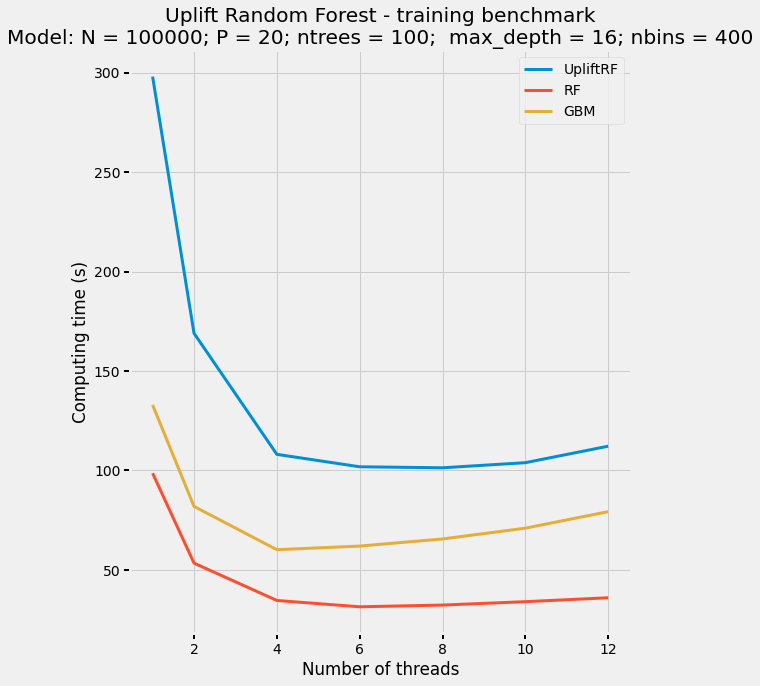

In [24]:
plot_result(uplift_time1, rf_time1, gbm_time1)

In [25]:
N = 100000
P = 20
max_depth = 16
nbins_top_level=2500
nbins=nbinss[2]
print(f"nbins = {nbins}")

df, x_names, treatment_column, response_column = syntetic_data(N, P)

nbins = 2000


In [26]:
uplift_time2, rf_time2, gbm_time2 = run_benchmark(df)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjftx_8_h
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjftx_8_h\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjftx_8_h\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_5df6r5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 380.03233456611633s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.57710242271423s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 289.31641364097595s
H2O session _sid_bb97 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpu6ygoz20
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpu6ygoz20\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpu6ygoz20\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_g428gk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 371.95351576805115s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.45786261558533s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 291.51924204826355s
H2O session _sid_b103 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpc9a7t43u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpc9a7t43u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpc9a7t43u\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_pgeeqx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 382.18108892440796s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.83283567428589s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 295.2986526489258s
H2O session _sid_ab5e closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoya73z5x
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoya73z5x\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoya73z5x\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1steaq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 376.8437201976776s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.3238456249237s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 292.19815278053284s
H2O session _sid_9f3c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_blpng7d
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_blpng7d\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_blpng7d\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_50bd0v
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 380.87038707733154s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.74937772750854s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 294.61061120033264s
H2O session _sid_8de2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpzp56v5nr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpzp56v5nr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpzp56v5nr\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ov10i5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 380.16562390327454s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.65440845489502s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 293.74466276168823s
H2O session _sid_bd52 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_7o21n9j
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_7o21n9j\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_7o21n9j\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_cncj6u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 375.93736004829407s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.82022762298584s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 292.787358045578s
H2O session _sid_9be7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpd4plxncx
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpd4plxncx\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpd4plxncx\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_cibb7w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 381.5103690624237s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 107.48189520835876s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 298.6023027896881s
H2O session _sid_9278 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_2yhkgsb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_2yhkgsb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_2yhkgsb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_yz65ax
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 371.845983505249s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 105.89002966880798s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 296.40129494667053s
H2O session _sid_b9d9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpsxkmkark
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpsxkmkark\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpsxkmkark\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_k7cr4s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 375.414204120636s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 106.58079147338867s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 298.33352184295654s
H2O session _sid_9140 closed.
Uplift 377.6754587173462s
RF 106.7368376493454s
gbm 294.2812212705612s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpq9jc7rn9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpq9jc7rn9\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gnlv8q
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 341.97246170043945s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.80421829223633s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 266.4020366668701s
H2O session _sid_970c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphlj911ye
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphlj911ye\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphlj911ye\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2vh4an
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 338.11938667297363s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.04178357124329s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 270.5548551082611s
H2O session _sid_a64c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpemx3hc91
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpemx3hc91\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpemx3hc91\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_g4gnbr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 339.1008942127228s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.62173843383789s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 267.99723625183105s
H2O session _sid_8890 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwyti8b57
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwyti8b57\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwyti8b57\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bfwl7b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 338.46648645401s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.96062541007996s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 265.58621764183044s
H2O session _sid_8c5c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpmlepnmx2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpmlepnmx2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpmlepnmx2\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1vk9n4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 348.27518463134766s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.88734936714172s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 267.99260115623474s
H2O session _sid_b696 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwjvcm8w3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwjvcm8w3\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwjvcm8w3\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_2ab2la
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 348.55222034454346s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.78922462463379s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 273.50775122642517s
H2O session _sid_9717 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpbibo667w
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpbibo667w\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpbibo667w\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_d5b58n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 346.4059989452362s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 99.13359594345093s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 269.62195682525635s
H2O session _sid_96fa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpz7j1gaet
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpz7j1gaet\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpz7j1gaet\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_30gro5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 340.966032743454s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.6104302406311s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 266.03250646591187s
H2O session _sid_8e0c closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkro52ifs
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkro52ifs\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpkro52ifs\h2o_potte_started_from_python.err

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_cvhwie
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 339.8143527507782s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 97.65478420257568s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 272.2819221019745s
H2O session _sid_80ff closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpby4apmk0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpby4apmk0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpby4apmk0\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bcr2od
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 339.68469738960266s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 98.39556884765625s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 265.53628039360046s
H2O session _sid_9b18 closed.
Uplift 342.1357715845108s
RF 98.58993189334869s
gbm 268.5513363838196s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpknkqp4n3
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpknkqp4n3\h2o_potte_started_from_python.out
  JVM stderr: C:\Us

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_1x71ip
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 321.53862595558167s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.71304273605347s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.95039319992065s
H2O session _sid_9ec4 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpss59od_m
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpss59od_m\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpss59od_m\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_h9uc73
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 315.92314052581787s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 92.01984143257141s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 244.95108485221863s
H2O session _sid_b78f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgqc2e9d7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgqc2e9d7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgqc2e9d7\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bcncwx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 318.5483524799347s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.70628309249878s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 244.71491265296936s
H2O session _sid_b2a1 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpb31rufz5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpb31rufz5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpb31rufz5\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_cwyhcd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 320.1902370452881s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.80845594406128s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.23578786849976s
H2O session _sid_8b77 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxitl3xa1
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxitl3xa1\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxitl3xa1\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_r0iuqx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 319.0485870838165s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.65637707710266s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.77551794052124s
H2O session _sid_85c7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo8qgqhfu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo8qgqhfu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo8qgqhfu\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_at0yhw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 320.37357211112976s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 91.95679903030396s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 247.64721059799194s
H2O session _sid_a46f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcx1e7ri8
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcx1e7ri8\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcx1e7ri8\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ofnesf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 317.8796453475952s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.48843121528625s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 249.51410388946533s
H2O session _sid_aec8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpcm7iivpg
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpcm7iivpg\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpcm7iivpg\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7jv8dq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 318.34009170532227s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 93.30849623680115s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 244.47566270828247s
H2O session _sid_bc50 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpy9lju7sq
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpy9lju7sq\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpy9lju7sq\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6ocmbw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 316.8985242843628s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.78446388244629s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.83252549171448s
H2O session _sid_8e4a closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpov50ixrb
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpov50ixrb\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpov50ixrb\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7n1l7c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 323.92234110832214s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 90.84368515014648s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 245.71660161018372s
H2O session _sid_aa79 closed.
Uplift 319.2663117647171s
RF 91.22858757972718s
gbm 245.98138008117675s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp39tcup1a
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp39tcup1a\h2o_potte_started_from_python.out
  JVM stderr: C:\U

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xkapjj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 301.6105179786682s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.02237367630005s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 225.3791971206665s
H2O session _sid_b4c9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp60430p1_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp60430p1_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp60430p1_\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gqvw9a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 306.58137941360474s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.4637222290039s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.40267062187195s
H2O session _sid_bf9b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnzz237o6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnzz237o6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnzz237o6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_6olo27
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 307.467205286026s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.11114573478699s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.16678953170776s
H2O session _sid_b2b0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp7vhy7gkv
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp7vhy7gkv\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp7vhy7gkv\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_zl5w8t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 302.7893521785736s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.24438881874084s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.6272897720337s
H2O session _sid_8191 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp6r7yatb_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp6r7yatb_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp6r7yatb_\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_gwwui9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 302.57588362693787s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.65881395339966s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 226.98523092269897s
H2O session _sid_b37d closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpximkd6aa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpximkd6aa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpximkd6aa\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_whkppq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 301.5743758678436s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.78099322319031s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.8994119167328s
H2O session _sid_8a98 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8g4yw8bi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8g4yw8bi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8g4yw8bi\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_ndzrfp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 308.3145079612732s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.82970809936523s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.60100841522217s
H2O session _sid_ba38 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpgibny_e4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpgibny_e4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpgibny_e4\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_xudrk0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 303.95169043540955s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.70989108085632s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 223.42414379119873s
H2O session _sid_a654 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpxs3amsmu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpxs3amsmu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpxs3amsmu\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_k4q9al
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 307.2739191055298s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.74991178512573s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 222.45294952392578s
H2O session _sid_ada9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4kd7gpa0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4kd7gpa0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4kd7gpa0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_87wg4s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 304.5333893299103s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.68075060844421s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 221.9214482307434s
H2O session _sid_a5eb closed.
Uplift 304.6672221183777s
RF 84.22516992092133s
gbm 223.58601398468016s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp68yew7hh
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp68yew7hh\h2o_potte_started_from_python.out
  JVM stderr: C:\Use

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bpigxk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 293.86731696128845s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.88472509384155s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.3111264705658s
H2O session _sid_815f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_2362z9o
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_2362z9o\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_2362z9o\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_n2cjtb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 294.5037930011749s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.88505458831787s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 205.77876472473145s
H2O session _sid_83c8 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo5zrfuwm
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo5zrfuwm\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo5zrfuwm\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_l1v2ab
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 295.3817732334137s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 83.85888600349426s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.05845308303833s
H2O session _sid_aaaa closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphg18k085
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphg18k085\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphg18k085\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_uobm1a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 297.620539188385s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 86.04591536521912s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.24197626113892s
H2O session _sid_8fbc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpriqr7enu
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpriqr7enu\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpriqr7enu\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_g9nejx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 296.85607957839966s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.5226309299469s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 203.73825407028198s
H2O session _sid_9234 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpuwaxgyu7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpuwaxgyu7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpuwaxgyu7\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_c72k1x
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 294.91904044151306s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.1887936592102s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 205.35138726234436s
H2O session _sid_acc0 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpnpbo5gre
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpnpbo5gre\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpnpbo5gre\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_odgw0j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 294.30455684661865s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 84.19638514518738s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 212.7133502960205s
H2O session _sid_aec9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp44yok5pa
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp44yok5pa\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp44yok5pa\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_eswn2f
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 302.44950556755066s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 87.29626059532166s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 210.0716187953949s
H2O session _sid_b212 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpwo_i4n_6
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpwo_i4n_6\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpwo_i4n_6\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_j7gs5a
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 301.1662600040436s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 89.32738518714905s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 204.88146448135376s
H2O session _sid_a0ea closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphnrdic1z
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphnrdic1z\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphnrdic1z\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_u2i8vj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 295.8765411376953s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 85.28329658508301s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 206.42161393165588s
H2O session _sid_a07b closed.
Uplift 296.6945405960083s
RF 85.6489333152771s
gbm 206.7568009376526s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpkym6_wia
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpkym6_wia\h2o_potte_started_from_python.out
  JVM stderr: C:\User

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_y2aiab
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 398.98267126083374s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 119.6020200252533s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.44628643989563s
H2O session _sid_8f72 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1_uf8qim
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1_uf8qim\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1_uf8qim\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_qpo8sq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 394.08761620521545s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 123.67396593093872s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.131489276886s
H2O session _sid_afbb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk_tk7w16
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk_tk7w16\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk_tk7w16\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_nu7lbi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 400.5779767036438s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 120.40023303031921s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.52346992492676s
H2O session _sid_b0a7 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpeehjrpx7
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpeehjrpx7\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpeehjrpx7\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bukgn1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 395.56138157844543s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 120.75770568847656s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 232.88401532173157s
H2O session _sid_8d98 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp54udjywr
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp54udjywr\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp54udjywr\h2o_potte_started_from_python

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_8jdksh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 401.7412874698639s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 117.65334987640381s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 239.20733261108398s
H2O session _sid_86f9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp_h6um26u
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp_h6um26u\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp_h6um26u\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_d23i6b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 400.4574182033539s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 124.20629334449768s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.07253336906433s
H2O session _sid_bfbb closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpk6239qx5
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpk6239qx5\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpk6239qx5\h2o_potte_started_from_python.

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_sf708o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 400.7032980918884s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 117.58279538154602s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 238.7307960987091s
H2O session _sid_b6bc closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4xgf5yw9
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4xgf5yw9\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4xgf5yw9\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_w6unt7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 401.7636351585388s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 121.2817599773407s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.02513098716736s
H2O session _sid_ad98 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpewbwqsu0
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpewbwqsu0\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpewbwqsu0\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_71ce5n
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 400.7153661251068s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 118.9548282623291s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 237.5932321548462s
H2O session _sid_ac22 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp2y9p1txi
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp2y9p1txi\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp2y9p1txi\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_lczdcr
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 398.03978872299194s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 119.42735838890076s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 240.53516387939453s
H2O session _sid_9156 closed.
Uplift 399.2630439519882s
RF 120.35403099060059s
gbm 237.91494500637054s
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmps7b8sqad
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmps7b8sqad\h2o_potte_started_from_python.out
  JVM stderr: C:

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_bj0b49
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 673.2262899875641s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 222.6573519706726s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 361.4535746574402s
H2O session _sid_a1f2 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp1ge8kvi4
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp1ge8kvi4\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp1ge8kvi4\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_7vipss
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 669.2591319084167s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 220.19353866577148s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 352.6088740825653s
H2O session _sid_a09b closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmphre_q5xe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmphre_q5xe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmphre_q5xe\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_k01jiz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 671.422824382782s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 218.26814007759094s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 352.0051918029785s
H2O session _sid_b6ed closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpprfoeggw
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpprfoeggw\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpprfoeggw\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_9h0d1u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 676.2639157772064s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 220.4542510509491s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 364.8540623188019s
H2O session _sid_b535 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpjplppsv2
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpjplppsv2\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpjplppsv2\h2o_potte_started_from_python.er

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_potte_4yasda
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 662.6084718704224s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 224.9940528869629s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 362.87086057662964s
H2O session _sid_b25f closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp5qswambo
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp5qswambo\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp5qswambo\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_2xzfxf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 664.1771268844604s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 219.25275564193726s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 360.8370659351349s
H2O session _sid_9238 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpoehnpdsz
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpoehnpdsz\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpoehnpdsz\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_wlg3qh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 676.2759637832642s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 223.59404134750366s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 361.6671049594879s
H2O session _sid_b2e9 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpss9az1kj
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpss9az1kj\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpss9az1kj\h2o_potte_started_from_python.e

H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ncprhk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 677.0135753154755s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 226.0818588733673s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 364.12409687042236s
H2O session _sid_b045 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp8oh8a_oe
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp8oh8a_oe\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp8oh8a_oe\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_rjvvtn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 671.1343500614166s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 220.51191115379333s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 356.3110382556915s
H2O session _sid_8604 closed.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmp4xagbxs_
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmp4xagbxs_\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmp4xagbxs_\h2o_potte_started_from_python.e

H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Prague
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.35.0.99999
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_potte_ua6u8b
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.27 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Uplift Time: 672.2888252735138s
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
RF Time: 215.09834170341492s
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Time: 360.4618000984192s
H2O session _sid_8aab closed.
Uplift 671.3670475244522s
RF 221.11062433719636s
gbm 359.71936695575715s
12 - Uplift = 377.6754587173462, RF = 106.7368376493454, gbm = 294.2812212705612
10 - Uplift = 342.1357715845108, RF = 98.58993189334869, gbm = 268.5513363838196
8 - Uplift = 319.2663117647171, RF = 91.22858757972718, gbm = 245.98138008117675
6 - Uplift = 304.6672221183777, RF = 84.22516992092133, gbm = 223.58601398468016
4 - Uplift = 296.6945405960083, RF = 85.6489333152771, gbm = 206.7568009376526
2 - Uplift = 399.2630439

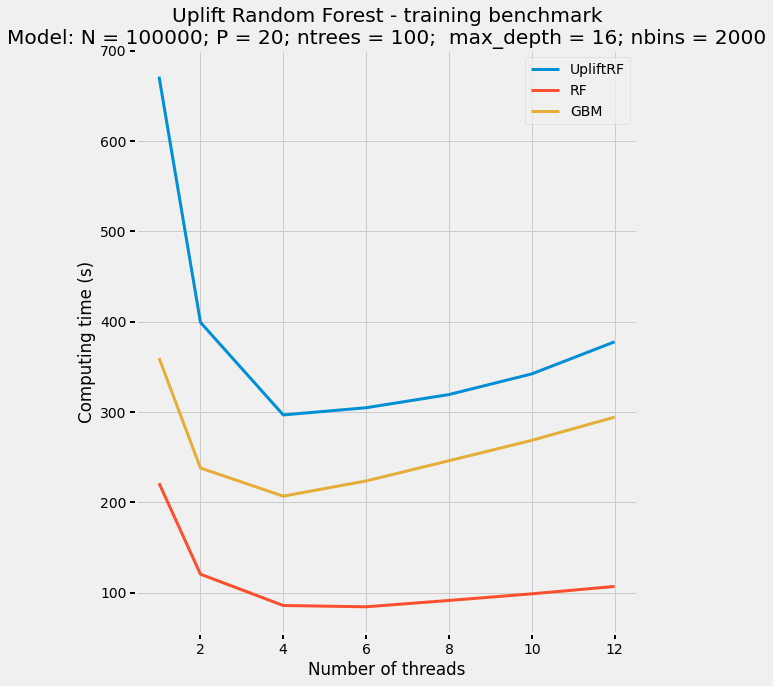

In [27]:
plot_result(uplift_time2, rf_time2, gbm_time2)

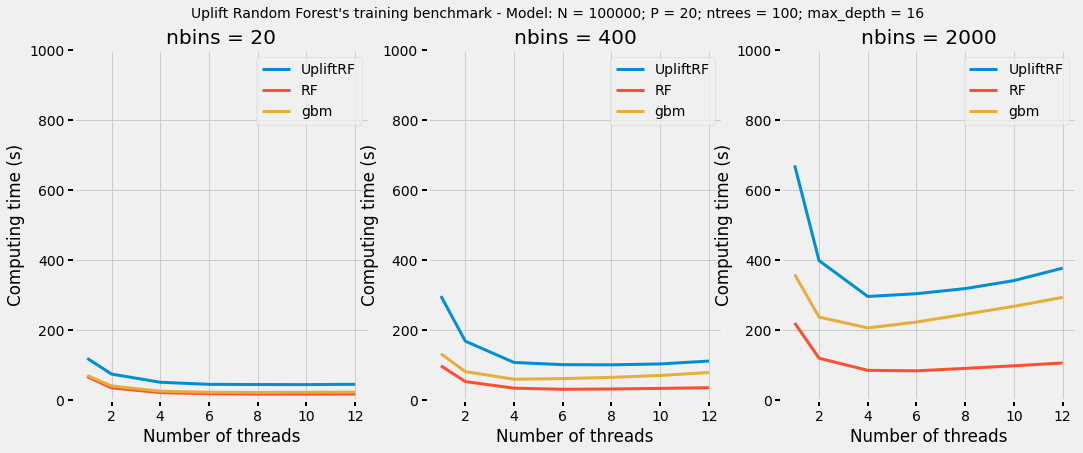

In [28]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf = [rf_time0, rf_time1, rf_time2]
all_predict_gbm = [gbm_time0, gbm_time1, gbm_time2]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time, gbm_time, i in zip(all_predict_uplift, all_predict_rf, all_predict_gbm, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF", linewidth=3)    
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"gbm", linewidth=3)    
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 1000)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()

In [29]:
print(all_predict_uplift)

[{12: 45.76174855232239, 10: 44.832258462905884, 8: 45.05838401317597, 6: 45.6469190120697, 4: 51.57243311405182, 2: 74.91841149330139, 1: 119.93476831912994}, {12: 112.20762398242951, 10: 103.92781813144684, 8: 101.35550203323365, 6: 101.86868731975555, 4: 108.11211912631988, 2: 168.9748759508133, 1: 297.98417954444886}, {12: 377.6754587173462, 10: 342.1357715845108, 8: 319.2663117647171, 6: 304.6672221183777, 4: 296.6945405960083, 2: 399.2630439519882, 1: 671.3670475244522}]


In [30]:
print(all_predict_rf)

[{12: 17.910662627220155, 10: 17.8006267786026, 8: 17.905582189559937, 6: 18.90407328605652, 4: 21.997461557388306, 2: 35.50527763366699, 1: 67.41014728546142}, {12: 36.033280873298644, 10: 34.058710765838626, 8: 32.35181894302368, 6: 31.487108206748964, 4: 34.6623411655426, 2: 53.415688920021054, 1: 98.64351460933685}, {12: 106.7368376493454, 10: 98.58993189334869, 8: 91.22858757972718, 6: 84.22516992092133, 4: 85.6489333152771, 2: 120.35403099060059, 1: 221.11062433719636}]


In [31]:
print(all_predict_gbm)

[{12: 23.398007535934447, 10: 22.97642402648926, 8: 22.431343364715577, 6: 22.998206114768983, 4: 26.016852974891663, 2: 40.8144492149353, 1: 71.03258996009826}, {12: 79.30407712459564, 10: 71.01147482395172, 8: 65.5779593706131, 6: 62.00581922531128, 4: 60.18950023651123, 2: 81.94848034381866, 1: 132.92951061725617}, {12: 294.2812212705612, 10: 268.5513363838196, 8: 245.98138008117675, 6: 223.58601398468016, 4: 206.7568009376526, 2: 237.91494500637054, 1: 359.71936695575715}]


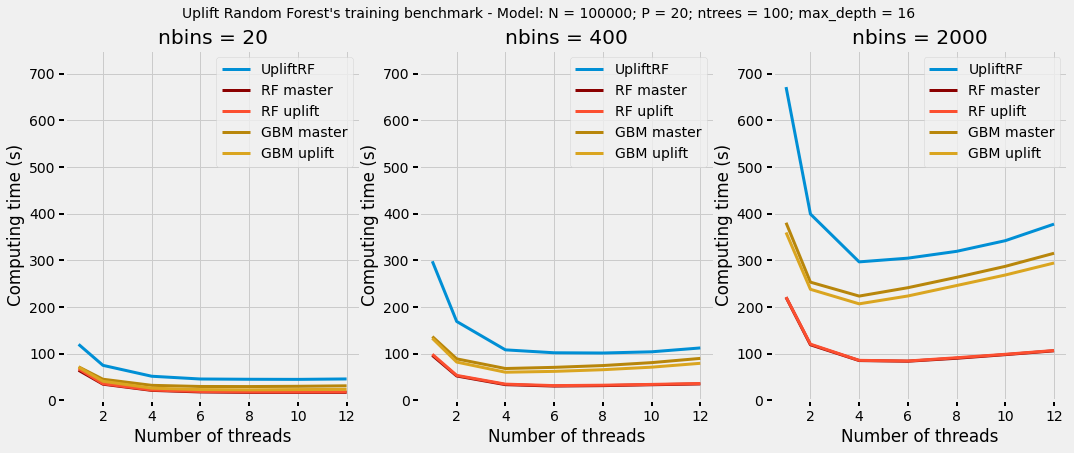

In [32]:
all_predict_uplift = [uplift_time0, uplift_time1, uplift_time2]
all_predict_rf_uplift = [rf_time0, rf_time1, rf_time2]
all_predict_gbm_uplift = [gbm_time0, gbm_time1, gbm_time2]
all_predict_gbm_master = [{12: 31.045402455329896, 10: 30.003125166893007, 8: 29.459724402427675, 6: 29.618798065185548, 4: 32.065751457214354, 2: 45.13592867851257, 1: 71.67515115737915}, {12: 89.81329185962677, 10: 80.74043428897858, 8: 74.46653089523315, 6: 70.61683766841888, 4: 68.13480970859527, 2: 88.81703267097473, 1: 136.62510740756989}, {12: 315.1842556476593, 10: 287.11348288059236, 8: 263.5495444536209, 6: 241.33826262950896, 4: 223.3799422979355, 2: 253.20618925094604, 1: 380.59573593139646}]
all_predict_rf_master = [{12: 16.969228744506836, 10: 16.93504798412323, 8: 16.9992112159729, 6: 17.891290044784547, 4: 21.27529604434967, 2: 34.54790048599243, 1: 64.3570431470871}, {12: 35.09399790763855, 10: 33.34315853118896, 8: 31.443611669540406, 6: 30.545160150527956, 4: 33.5466162443161, 2: 52.15320856571198, 1: 96.24524054527282}, {12: 106.10161943435669, 10: 97.87103872299194, 8: 90.09002497196198, 6: 83.78771808147431, 4: 85.18966431617737, 2: 119.04548950195313, 1: 220.81866981983185}]

fig=plt.figure(figsize=(16,6))
fig.suptitle(f"Uplift Random Forest's training benchmark - Model: N = {N}; P = {P}; ntrees = {ntrees}; max_depth = {max_depth}", fontsize=14)

for uplift_time, rf_time_master, rf_time_uplift, gbm_time_master, gbm_time_uplift, i in zip(all_predict_uplift, all_predict_rf_master, all_predict_rf_uplift, all_predict_gbm_master, all_predict_gbm_uplift, range(1, len(nbinss) + 1)):
    fig.add_subplot(130 + i)
    data = {"x":[], "y": [], "label":[]}
    for label, coord in uplift_time.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"UpliftRF", linewidth=3)

    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF master", linewidth=3, color = "darkred")   
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in rf_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"RF uplift", linewidth=3)     
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_master.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM master", linewidth=3, color = "darkgoldenrod")  
    
    data = {"x":[], "y": [], "label":[]}
    for label, coord in gbm_time_uplift.items():
        data["x"].append(label)
        data["y"].append(coord)
    plt.plot(data['x'], data['y'], '-', label=f"GBM uplift", linewidth=3, color="goldenrod")      
    
    plt.xlabel("Number of threads")
    plt.ylabel("Computing time (s)")
    plt.ylim(0, 750)
    plt.legend()
    plt.tick_params(direction='out', length=6, width=2) 
    plt.title(f"nbins = {nbinss[i - 1]}")

plt.savefig(f"h2o-train-perf-nbins-all{random.random()}.png", bbox_inches='tight', pad_inches=.05)
plt.show()